**1. Install and upgrade core dependencies**

The following cell ensures you have the latest versions of the key libraries used in this notebook:

In [ ]:
%pip install --upgrade \
  datasets \
  fsspec \
  transformers \
  sklearn-crfsuite \
  seqeval \
  pandas \
  gradio==3.45 \
  joblib \
  evaluate \
  fastapi \
  uvicorn

  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)


**2. Import all necessary libraries and modules**

This cell sets up the full environment by importing all core libraries required for preprocessing, modeling, evaluation, and interaction:

---

**System and Utility**  
- `os`, `time`, `json`: File handling, logging, and timing operations  
- `logging`: For structured console/debug logging

**Numerical & Data Manipulation**  
- `numpy`, `pandas`: Efficient data handling and manipulation  
- `matplotlib.pyplot`: Visualization (e.g., F1 scores, confusion matrix)

**PyTorch**  
- `torch`, `nn`: For potential deep learning models

**NLTK (Natural Language Toolkit)**  
- `nltk`, `pos_tag`, `PorterStemmer`, `ngrams`: Tokenization, stemming, n-gram generation

**Gradio**  
- `gr`: UI component for interactive demos

**Hugging Face Datasets**  
- `load_dataset`: Load prebuilt datasets (like CoNLL-2003, etc.)

**scikit-learn & sklearn-crfsuite**  
- `FeatureHasher`, `train_test_split`: Hashing & splitting utilities  
- `CRF`, `metrics`, `flat_classification_report`, `flatten`: CRF modeling and evaluation

**Hugging Face Transformers**  
- `AutoTokenizer`, `AutoModelForTokenClassification`: Pretrained transformer models for token-level tasks  
- `TrainingArguments`, `Trainer`: Training utilities for fine-tuning models

**Colab Drive**  
- `google.colab.drive`: Mount and use Google Drive for persistent storage

**SeqEval**  
- `classification_report`: Evaluation metrics tailored for sequence labeling (NER, POS tagging, etc.)

**Joblib**  
- `joblib`: Efficient model serialization/deserialization


In [ ]:
# Standard library imports
import os
import time
import json
import logging
from collections import defaultdict

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from datasets import load_dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    BertTokenizerFast,
    BertForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    get_scheduler
)
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite.utils import flatten
import joblib
import gradio as gr
from tqdm.auto import tqdm
import nltk
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from seqeval.metrics import classification_report

# Local application imports
from google.colab import drive


**3. Setup NLTK and Mount Google Drive**

---

**NLTK Resource Setup**  
Before processing text, we ensure that essential NLTK resources are available locally:

- `'punkt'`: Tokenizer for sentence and word splitting  
- `'averaged_perceptron_tagger'` & `'averaged_perceptron_tagger_eng'`: Part-of-speech taggers

Each resource is checked and downloaded only if missing, ensuring a reproducible environment without redundant downloads.

```python
for res in ['averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng', 'punkt']:
    try:
        nltk.data.find(f'taggers/{res}')
    except LookupError:
        nltk.download(res)
```

**Safe Google Drive Mount (Clean Remount)**  
To avoid ValueError due to existing files in /content/drive, we:
- Forcefully remove any previous or corrupted mount point.
- Perform a clean remount of Google Drive using force_remount=True.

```python
!rm -rf /content/drive
drive.mount('/content/drive', force_remount=True)
```


In [ ]:
# 1. Imports and NLTK setup
for res in ['averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng', 'punkt']:
    try:
        nltk.data.find(f'taggers/{res}')
    except LookupError:
        nltk.download(res)

# 2. Clean any stale mount and remount Google Drive
!rm -rf /content/drive
drive.mount('/content/drive', force_remount=True)

rm: cannot remove '/content/drive/.file-revisions-by-id': Operation canceled
rm: cannot remove '/content/drive/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.shortcut-targets-by-id': Operation canceled
rm: cannot remove '/content/drive/.Trash-0': Directory not empty
rm: cannot remove '/content/drive/.Encrypted/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.Encrypted/.shortcut-targets-by-id': Operation canceled


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mounted at /content/drive


### CRF Utilities and Pipeline Setup

This cell defines a comprehensive suite of utility functions to **train, evaluate, and manage a CRF (Conditional Random Field) model**, along with feature extraction and structured logging.

---

#### Key Components:

- ** Model Path & Logging**
  - `MODEL_PATH`: Predefined path on Google Drive for saving the best CRF model.
  - Python's `logging` module is configured for detailed, timestamped logging.

- ** Model Saving & Loading**
  - `save_model(...)`: Serializes and stores the CRF model using `joblib`.
  - `load_model(...)`: Loads a saved CRF model from disk.
  - `ensure_dir_exists(...)`: Ensures the directory structure for model persistence exists.

- ** Training & Evaluation**
  - `train_crf_model(...)`: Fits the CRF model on training data.
  - `evaluate_model(...)`: Uses `seqeval` to generate classification reports for model performance.

- ** Visualization**
  - `plot_f1_scores(...)`: Visualizes F1-score distribution across tags using `matplotlib`.

- ** Data Validation**
  - `validate_data_shapes(...)`: Ensures input features and labels align before training.

---

#### Feature Engineering:

A modular set of feature functions used to transform tokenized text into CRF-suitable features:

- `get_word_features`: Lowercased form, stem, and word length  
- `get_ngram_features`: Includes bigram and trigram context  
- `get_context_features`: Previous and next word context  
- `get_orthographic_features`: Capitalization, digits, hyphens, prefixes/suffixes  
- `extract_common_features`: Aggregates all the above into a final token-level feature set

---

#### Main Pipeline:

- `run_crf_pipeline(...)`: End-to-end execution pipeline for:
  1. Feature extraction
  2. Data validation
  3. Model training
  4. Model saving
  5. Evaluation on validation & test sets
  6. F1 visualization

Use this modular structure to support flexible experimentation with different feature sets or model hyperparameters.


In [ ]:
LOG_PATH   = '/content/drive/MyDrive/NLP_CW/logs/predictions.jsonl'

CRF1_MODEL_PATH = '/content/drive/MyDrive/NLP_CW/models/crf1_model.joblib'
CRF2_MODEL_PATH = '/content/drive/MyDrive/NLP_CW/models/crf2_model.joblib'
BERT_MODEL_PATH = '/content/drive/MyDrive/NLP_CW/models/bert_model.joblib'

# Setup logger for detailed traceability
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

stemmer = PorterStemmer()

def print_section_separator():
    print("=" * 50)

def ensure_dir_exists(path):
    """Ensure the directory for a given path exists."""
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        logger.info(f"Created directory: {directory}")
    else:
        logger.debug(f"Directory already exists: {directory}")


def save_model(model, model_path):
    """Save the trained model to disk."""
    try:
        ensure_dir_exists(model_path)
        joblib.dump(model, model_path)
        logger.info(f"Model saved successfully at: {model_path}")
    except Exception as e:
        logger.error(f"Error saving model: {e}")
        raise

def load_model(model_path):
    """Load a saved CRF model."""
    try:
        model = joblib.load(model_path)
        logger.info(f"Model loaded from: {model_path}")
        return model
    except Exception as e:
        logger.error(f"Error loading model: {e}")
        raise


def extract_features(featurizer_func, tokens_list):
    """Apply featurizer function on list of token sequences."""
    logger.info(f"Extracting features for {len(tokens_list)} sequences.")
    try:
        return [featurizer_func(sentence) for sentence in tokens_list]
    except Exception as e:
        logger.error(f"Feature extraction failed: {e}")
        raise


def train_crf_model(crf_model, X_train, y_train):
    """Train the CRF model."""
    logger.info(f"Training CRF model on {len(X_train)} samples.")
    try:
        crf_model.fit(X_train, y_train)
        logger.info("CRF training completed.")
        return crf_model
    except Exception as e:
        logger.error(f"Training failed: {e}")
        raise


def evaluate_model(crf_model, X_eval, y_true, dataset_name="Evaluation"):
    """Evaluate the model and print classification report."""
    logger.info(f"Evaluating model on {dataset_name} set with {len(X_eval)} samples.")
    try:
        y_pred = crf_model.predict(X_eval)
        report = classification_report(y_true, y_pred)
        print(f"\n=== {dataset_name} Set Classification Report ===")
        print(report)
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        logger.info(f"{dataset_name} evaluation completed.")
        return report_dict
    except Exception as e:
        logger.error(f"Evaluation failed: {e}")
        raise


def plot_f1_scores(report_dict, variation_name):
    """Plot F1 scores for each label from the classification report."""
    labels, f1_scores = [], []
    for label, metrics in report_dict.items():
        if label not in ("accuracy", "macro avg", "weighted avg"):
            labels.append(label)
            f1_scores.append(metrics.get("f1-score", 0.0))

    if not labels:
        logger.warning("No labels found to plot F1 scores.")
        return

    logger.info(f"Plotting F1 scores for variation: {variation_name}")
    x = np.arange(len(labels))
    plt.figure(figsize=(10, 5))
    plt.bar(x, f1_scores, color='skyblue')
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title(f'F1 Scores per Label - {variation_name}')
    plt.ylabel('F1 Score')
    plt.tight_layout()
    plt.show()


def validate_data_shapes(X, y, dataset_name):
    if len(X) != len(y):
        message = f"{dataset_name} feature/label length mismatch: {len(X)} vs {len(y)}"
        logger.error(message)
        raise ValueError(message)
    logger.info(f"{dataset_name} data shape validation passed.")


def run_crf_pipeline(
    featurizer_func,
    crf_model,
    dataset,
    train_data,
    val_data,
    test_data,
    model_path,
    variation_name="Unnamed Variation"
):
    """
    Runs a CRF training and evaluation pipeline.
    """

    logger.info(f"Starting CRF pipeline for: {variation_name}")

    train_tokens, train_tags = train_data
    val_tokens, val_tags = val_data
    test_tokens, test_tags = test_data

    # Feature extraction
    X_train = extract_features(featurizer_func, train_tokens)
    X_val = extract_features(featurizer_func, val_tokens)
    X_test = extract_features(featurizer_func, test_tokens)

    # Validate data integrity
    validate_data_shapes(X_train, train_tags, "Training")
    validate_data_shapes(X_val, val_tags, "Validation")
    validate_data_shapes(X_test, test_tags, "Test")

    # Train model
    crf_model = train_crf_model(crf_model, X_train, train_tags)

    # Save trained model
    save_model(crf_model, model_path)

    # Evaluate on validation and test sets
    val_report = evaluate_model(crf_model, X_val, val_tags, "Validation")
    test_report = evaluate_model(crf_model, X_test, test_tags, "Test")

    # Visualization of test results
    plot_f1_scores(test_report, variation_name)

    logger.info(f"CRF pipeline for '{variation_name}' completed.\n")

def get_word_features(word):
    return {
        'word': word.lower(),
        'stem': stemmer.stem(word),
        'length': len(word),
    }

def get_ngram_features(i, bigrams, trigrams):
    curr_bigram = bigrams[i] if i < len(bigrams) else ('<END>', '<END>')
    curr_trigram = trigrams[i] if i < len(trigrams) else ('<END>', '<END>', '<END>')
    return {
        'bigram': f"{curr_bigram[0].lower()}_{curr_bigram[1].lower()}",
        'trigram': f"{curr_trigram[0].lower()}_{curr_trigram[1].lower()}_{curr_trigram[2].lower()}",
    }

def get_context_features(sent, i):
    prev_word = sent[i-1].lower() if i > 0 else '<START>'
    next_word = sent[i+1].lower() if i < len(sent) - 1 else '<END>'
    return {
        'prev_word': prev_word,
        'next_word': next_word,
        'prev_next': f"{prev_word}_{next_word}",
    }

def get_orthographic_features(word):
    return {
        'is_cap': word[0].isupper(),
        'is_num': word.isdigit(),
        'has_hyphen': '-' in word,
        'prefix3': word[:3].lower(),
        'suffix3': word[-3:].lower(),
    }

def extract_common_features(sent, i, bigrams, trigrams):
    word = sent[i]

    features = {}
    features.update(get_word_features(word))
    features.update(get_ngram_features(i, bigrams, trigrams))
    features.update(get_context_features(sent, i))
    features.update(get_orthographic_features(word))

    return features

def setup_environment():
    print("[Setup] Disabling tokenizer parallelism and detecting device...")
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Setup] Using device: {device}")
    return device

### Dataset Loading and Inspection

This cell loads the **PLOD-CW-25** dataset from the Hugging Face Hub and provides a utility function to extract and print samples from each dataset split.

---

#### Key Steps:

- **Load dataset:**  
  Uses `load_dataset("surrey-nlp/PLOD-CW-25")` to retrieve the full dataset with predefined splits: `train`, `validation`, and `test`.

- **Function `get_and_print_split_data(dataset, split_name)`:**  
  - Extracts tokens, named entity recognition (NER) tags, and part-of-speech (POS) tags from the specified split.  
  - Prints the total number of samples in the split.  
  - Displays the first example's tokens, NER tags, and POS tags for quick inspection.  
  - Returns the tokens and tags to be used later in the pipeline.

In [ ]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

def get_and_print_split_data(dataset, split_name):
    tokens = dataset[split_name]['tokens']
    tags = dataset[split_name]['ner_tags']
    pos = dataset[split_name]['pos_tags']

    print(f"{split_name.capitalize()} samples: {len(tokens)}\n")
    print(f"First {split_name} example:")
    print(f"Tokens: {tokens[0]}")
    print(f"Tags:   {tags[0]}")
    print(f"POS:    {pos[0]}")
    print("-" * 50)

    return tokens, tags

train_data = get_and_print_split_data(dataset, 'train')
val_data = get_and_print_split_data(dataset, 'validation')
test_data = get_and_print_split_data(dataset, 'test')

Train samples: 2000

First train example:
Tokens: ['MRR', ',', 'mortality', 'rate', 'ratio', ';', 'TBI', ',', 'traumatic', 'brain', 'injury', '.']
Tags:   ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']
POS:    ['NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']
--------------------------------------------------
Validation samples: 150

First validation example:
Tokens: ['Multi', '-', 'locus', 'sequence', 'typing', '(', 'MLST', ')', 'was', 'performed', 'by', 'PCR', '-', 'sequencing', 'of', 'a', 'set', 'of', 'pneumococcal', 'housekeeping', 'genes', ',', 'including', 'ardE', ',', 'gdh', ',', 'gki', ',', 'recP', ',', 'spi', ',', 'xpt', ',', 'and', 'ddl', '[', '17', ']', '.']
Tags:   ['B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'O', 'O', 'O', 'B-AC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

# Experiment 1: Varying Vectorization Methods (3 Systems)

---

### **Systems:**

1. **System 1:**  
   Conditional Random Field (CRF) using **Basic Features** such as:  
   - Lowercased word  
   - Prefix (first 3 characters)  
   - Suffix (last 3 characters)

2. **System 2:**  
   CRF leveraging **Advanced Features**, including:  
   - Part-of-Speech (POS) tags  
   - N-gram features (bigrams, trigrams)  
   - Orthographic and contextual cues

3. **System 3:**  
   Deep learning approach using **BERT embeddings** combined with a Feed-Forward Neural Network (FFNN) classifier for token-level prediction.

---

This experiment evaluates the impact of feature engineering and representation complexity on sequence labeling performance, comparing traditional CRF-based systems with a contextualized embedding-based neural approach.


# System 1 : Conditional Random Field (CRF) using Basic Features


=== Validation Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.81      0.47      0.60       508
          LF       0.50      0.38      0.43       306

   micro avg       0.67      0.44      0.53       814
   macro avg       0.66      0.43      0.52       814
weighted avg       0.69      0.44      0.54       814


=== Test Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.80      0.44      0.57       797
          LF       0.55      0.43      0.48       482

   micro avg       0.69      0.44      0.53      1279
   macro avg       0.68      0.43      0.52      1279
weighted avg       0.71      0.44      0.54      1279



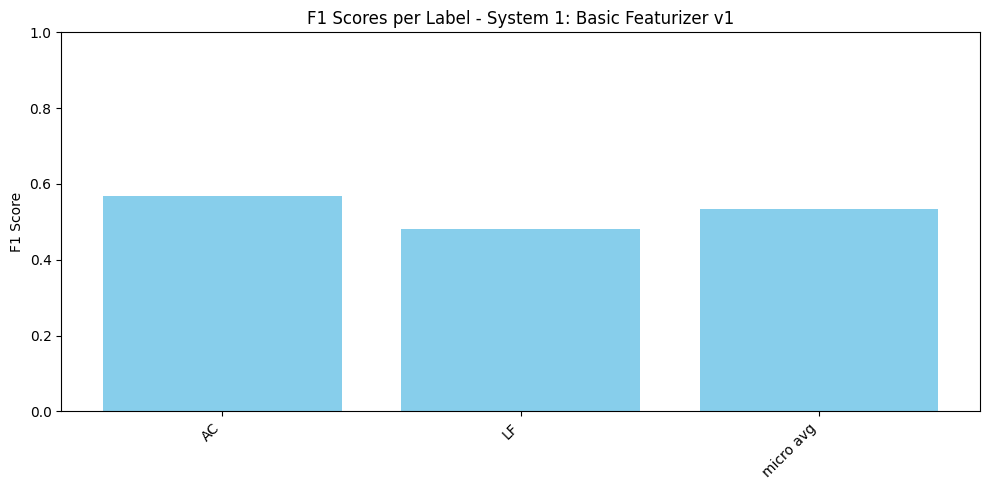


=== Validation Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.76      0.78      0.77       508
          LF       0.51      0.41      0.45       306

   micro avg       0.68      0.64      0.66       814
   macro avg       0.64      0.59      0.61       814
weighted avg       0.67      0.64      0.65       814


=== Test Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.74      0.78      0.76       797
          LF       0.56      0.44      0.50       482

   micro avg       0.68      0.66      0.67      1279
   macro avg       0.65      0.61      0.63      1279
weighted avg       0.67      0.66      0.66      1279



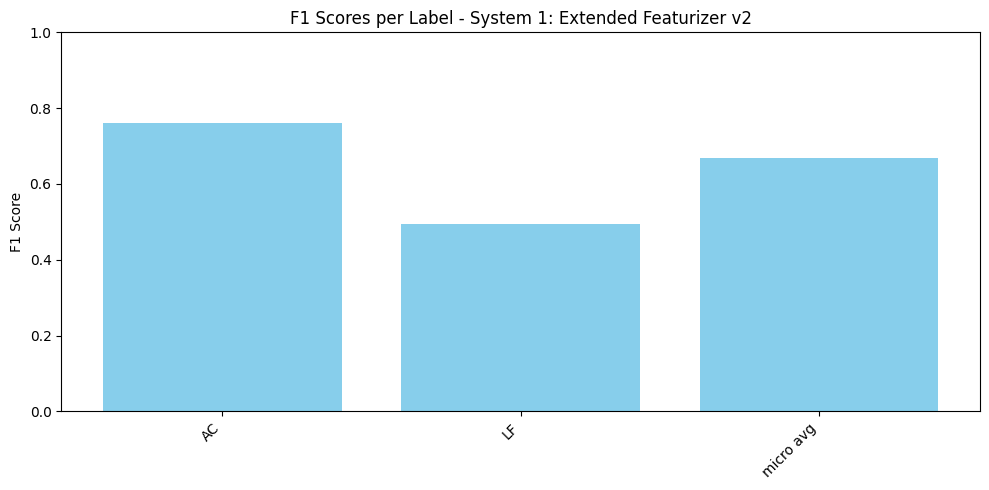

In [ ]:
# Variation 1: Basic Features
def basic_featurizer_v1(sent):
    return [{'word': word.lower(), 'suffix3': word[-3:].lower()} for word in sent]

# Variation 2: Extended Features
def basic_featurizer_v2(sent):
    return [{
        'word': word.lower(),
        'prefix3': word[:3].lower(),
        'suffix3': word[-3:].lower(),
        'is_cap': word[0].isupper(),
        'is_no_cap': word[0].islower()
    } for word in sent]

# Initialize model
sys1_crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.01,
    max_iterations=200,
    linesearch='StrongBacktracking',
    all_possible_transitions=True
)

# Run for both feature variations
run_crf_pipeline(
    basic_featurizer_v1,
    sys1_crf,
    dataset,
    train_data,
    val_data,
    test_data,
    model_path=CRF1_MODEL_PATH,
    variation_name="System 1: Basic Featurizer v1"
)

run_crf_pipeline(
    basic_featurizer_v2,
    sys1_crf,
    dataset,
    train_data,
    val_data,
    test_data,
    model_path=CRF1_MODEL_PATH,
    variation_name="System 1: Extended Featurizer v2"
)

# System 2: Advanced Feature Extraction with CRF

---

### Feature Extractors:

- **`advanced_featurizer_v1`**:  
  Extracts rich lexical features without incorporating POS tags, including:  
  - Word-level common features (stemming, orthographic cues)  
  - Bigram and trigram contextual features  

- **`advanced_featurizer_v2`**:  
  Extends `advanced_featurizer_v1` by adding detailed Part-of-Speech (POS) features:  
  - Current, previous, and next POS tags  
  - POS trigram feature to capture syntactic patterns

Both featurizers leverage NLTK’s POS tagging and n-gram extraction to boost the CRF’s contextual understanding.

---

### Model Configuration:

- **Algorithm:** L-BFGS optimizer  
- **Regularization:** c1=0.5 (L1), c2=0.01 (L2)  
- **Max iterations:** 200  
- **Line search:** StrongBacktracking  
- **Transitions:** All possible transitions enabled for sequence modeling


=== Validation Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.83      0.76      0.79       508
          LF       0.67      0.64      0.65       306

   micro avg       0.77      0.72      0.74       814
   macro avg       0.75      0.70      0.72       814
weighted avg       0.77      0.72      0.74       814


=== Test Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.85      0.80      0.82       797
          LF       0.71      0.67      0.69       482

   micro avg       0.79      0.75      0.77      1279
   macro avg       0.78      0.73      0.76      1279
weighted avg       0.79      0.75      0.77      1279



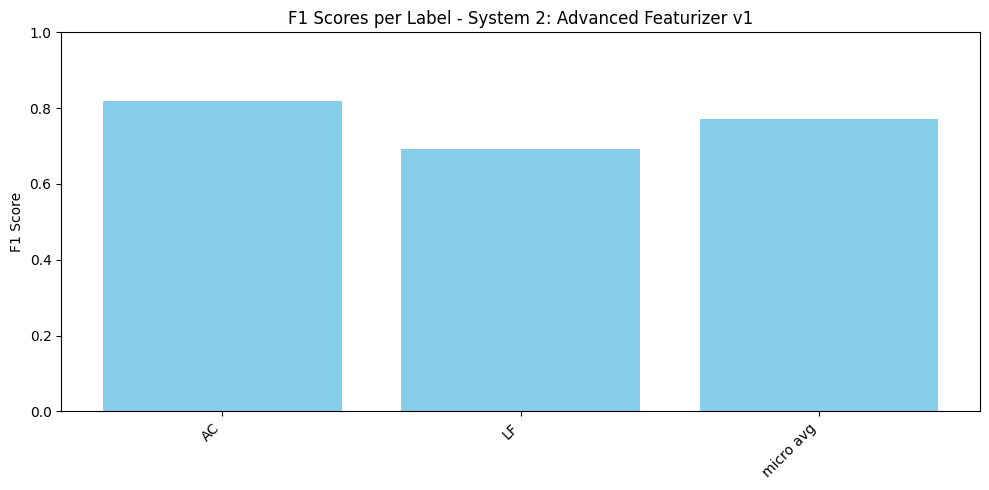


=== Validation Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.82      0.81      0.82       508
          LF       0.63      0.65      0.64       306

   micro avg       0.75      0.75      0.75       814
   macro avg       0.73      0.73      0.73       814
weighted avg       0.75      0.75      0.75       814


=== Test Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.83      0.84      0.84       797
          LF       0.71      0.69      0.70       482

   micro avg       0.79      0.78      0.79      1279
   macro avg       0.77      0.77      0.77      1279
weighted avg       0.79      0.78      0.79      1279



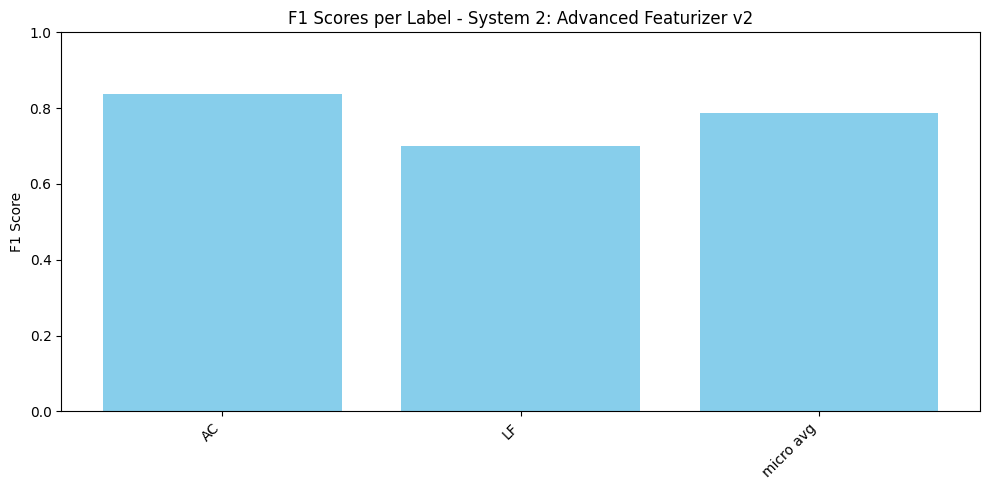

In [ ]:
def advanced_featurizer_v1(sent):
    """
    Feature extractor without POS tagging.

    :param sent: List of words in the sentence.
    :return: List of feature dictionaries for each word.
    """
    bigrams = list(ngrams(sent, 2))
    trigrams = list(ngrams(sent, 3))
    features = [extract_common_features(sent, i, bigrams, trigrams) for i in range(len(sent))]
    return features

def advanced_featurizer_v2(sent):
    """
    Feature extractor with POS tagging.

    :param sent: List of words in the sentence.
    :return: List of feature dictionaries for each word.
    """
    pos_tags = pos_tag(sent)
    bigrams = list(ngrams(sent, 2))
    trigrams = list(ngrams(sent, 3))
    features = []
    for i in range(len(sent)):
        feature = extract_common_features(sent, i, bigrams, trigrams)
        # Add POS features
        current_pos = pos_tags[i][1]
        prev_pos = pos_tags[i-1][1] if i > 0 else '<START_POS>'
        next_pos = pos_tags[i+1][1] if i < len(sent)-1 else '<END_POS>'
        feature.update({
            'pos': current_pos,
            'prev_pos': prev_pos,
            'next_pos': next_pos,
            'pos_trigram': f"{prev_pos}_{current_pos}_{next_pos}",
        })
        features.append(feature)
    return features

# Initialize model
sys2_crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.01,
    max_iterations=200,
    linesearch='StrongBacktracking',
    all_possible_transitions=True
)

run_crf_pipeline(
    advanced_featurizer_v1,
    sys2_crf,
    dataset,
    train_data,
    val_data,
    test_data,
    model_path=CRF2_MODEL_PATH,
    variation_name="System 2: Advanced Featurizer v1"
)

run_crf_pipeline(
    advanced_featurizer_v2,
    sys2_crf,
    dataset,
    train_data,
    val_data,
    test_data,
    model_path=CRF2_MODEL_PATH,
    variation_name="System 2: Advanced Featurizer v2"
)

# System 3: BERT + FFNN

---

### Overview

**System 3** integrates the **Bidirectional Encoder Representations from Transformers (BERT)** with a **Feedforward Neural Network (FFNN)** to perform token-level classification tasks, such as Named Entity Recognition (NER). This architecture leverages BERT's deep contextual embeddings, which capture rich semantic and syntactic information from text, and combines them with the expressive power of a feedforward network to make final predictions.

---

### Model Components

- **BERT (Bidirectional Encoder Representations from Transformers):**
  - Utilizes a transformer-based architecture to generate contextual embeddings for each token in the input sequence.
  - Pre-trained on large corpora, BERT captures intricate language patterns and relationships.
  - Fine-tuned on specific tasks to adapt its representations for downstream applications.

- **Feedforward Neural Network (FFNN):**
  - Comprises one or more fully connected layers.
  - Takes BERT's output embeddings as input and produces logits corresponding to each token's class label.
  - Typically includes activation functions like ReLU and softmax for classification tasks.

---

### Workflow

1. **Tokenization:** Input text is split into tokens using a tokenizer compatible with BERT, such as `BertTokenizerFast`.

2. **Embedding Generation:** Tokens are passed through BERT to obtain contextual embeddings.

3. **Classification:** The embeddings are fed into the FFNN, which outputs class probabilities for each token.

4. **Prediction:** The class with the highest probability is assigned to each token.

---

### Model Configuration

- **Optimizer:** AdamW
- **Learning Rate:** 5e-5
- **Epochs:** 3
- **Batch Size:** 16
- **Scheduler:** Linear warmup with no warmup steps
- **Evaluation Metric:** F1-score (calculated using the `seqeval` library)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train 1:   0%|          | 0/125 [00:00<?, ?it/s]

Eval Validation 1:   0%|          | 0/10 [00:00<?, ?it/s]

Train 2:   0%|          | 0/125 [00:00<?, ?it/s]

Eval Validation 2:   0%|          | 0/10 [00:00<?, ?it/s]

Train 3:   0%|          | 0/125 [00:00<?, ?it/s]

Eval Validation 3:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Validation 0:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Test 0:   0%|          | 0/16 [00:00<?, ?it/s]

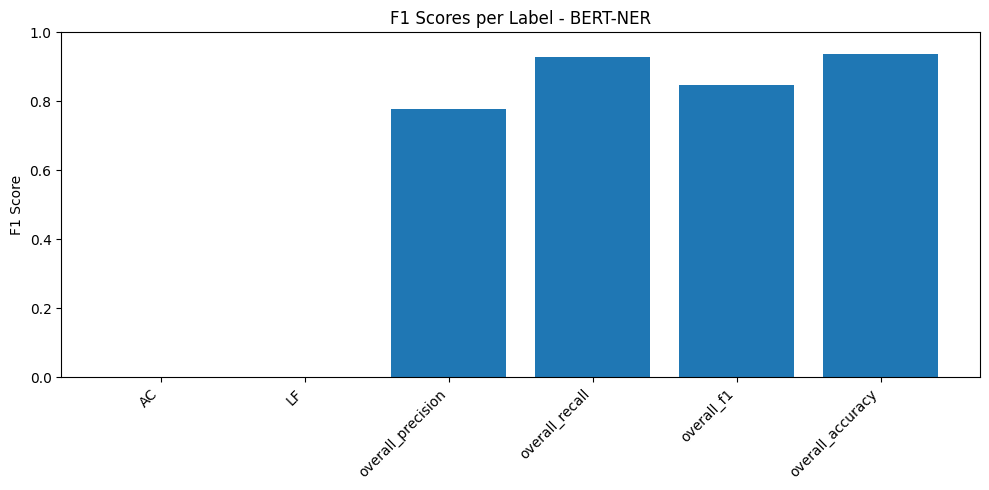

Predicting:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Epoch handlers and prediction logging
def train_epoch(model, loader, optimizer, scheduler, device, epoch):
    model.train()
    total_loss = 0.0
    logger.info(f"Starting training epoch {epoch}...")
    for batch in tqdm(loader, desc=f"Train {epoch}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        loss = model(**batch).loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    logger.info(f"Epoch {epoch} Training complete. Avg Loss: {avg_loss:.4f}")
    return avg_loss


def eval_model(model, loader, metric, device, id_to_label, epoch, dataset_name="Validation"):
    model.eval()
    preds, refs = [], []
    logger.info(f"Starting evaluation on {dataset_name} set (epoch {epoch})...")
    for batch in tqdm(loader, desc=f"Eval {dataset_name} {epoch}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(**batch).logits
        pred_ids = torch.argmax(logits, axis=-1).cpu().numpy()
        true_ids = batch['labels'].cpu().numpy()
        for p_seq, t_seq in zip(pred_ids, true_ids):
            p_tags, t_tags = [], []
            for pid, tid in zip(p_seq, t_seq):
                if tid != -100:
                    p_tags.append(id_to_label[pid])
                    t_tags.append(id_to_label[tid])
            preds.append(p_tags)
            refs.append(t_tags)
    # === DEBUG SAMPLE ===
    logger.info("Sample true tags: %s", refs[0][:20])
    logger.info("Sample pred tags: %s", preds[0][:20])
    # ====================
    results = metric.compute(predictions=preds, references=refs)
    logger.info(f"{dataset_name} Results (epoch {epoch}): {results}")
    return results


def plot_f1_scores(report_dict, variation_name):
    labels, f1_scores = [], []
    for label, metrics in report_dict.items():
        if label in ("accuracy", "macro avg", "weighted avg"):
            continue
        if isinstance(metrics, dict):
            f1 = metrics.get("f1-score", 0.0)
        else:
            f1 = float(metrics)
        labels.append(label)
        f1_scores.append(f1)
    if not labels:
        logger.warning("No labels found to plot F1 scores.")
        return
    logger.info(f"Plotting F1 scores for variation: {variation_name}")
    x = np.arange(len(labels))
    plt.figure(figsize=(10, 5))
    plt.bar(x, f1_scores)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title(f'F1 Scores per Label - {variation_name}')
    plt.ylabel('F1 Score')
    plt.tight_layout()
    plt.show()


def predict_and_log(model, tokenizer, loader, device, id_to_label, log_path):
    """Generate predictions and save them to a JSONL log."""
    ensure_dir_exists(log_path)
    logger.info(f"Saving predictions to {log_path}...")
    with open(log_path, 'w') as fw:
        for batch in tqdm(loader, desc="Predicting"):
            # extract inputs
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # forward
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_ids = torch.argmax(outputs.logits, axis=-1).cpu().numpy()
            # write per sample
            for tok_ids, p_seq in zip(input_ids.cpu().numpy(), pred_ids):
                words = tokenizer.convert_ids_to_tokens(tok_ids)
                labels = [id_to_label[i] for i in p_seq[:len(words)]]
                record = {'tokens': words, 'predictions': labels}
                fw.write(json.dumps(record) + ' ')
                logger.info("Finished saving predictions.")

# Pipeline functions
def setup_environment():
    logger.info("Disabling tokenizer parallelism and detecting device...")
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")
    return device


def load_data(dataset_name="surrey-nlp/PLOD-CW-25"):
    logger.info(f"Loading dataset: {dataset_name}...")
    raw_ds = load_dataset(dataset_name)
    logger.info(f"Loaded splits: {list(raw_ds.keys())}")
    return raw_ds


def build_label_mappings(raw_ds):
    logger.info("Building label mappings from training split...")
    all_tags = set(tag for tags in raw_ds["train"]["ner_tags"] for tag in tags)
    label_list = sorted(all_tags)
    label_to_id = {lbl: idx for idx, lbl in enumerate(label_list)}
    id_to_label = {idx: lbl for lbl, idx in label_to_id.items()}
    logger.info(f"Number of labels: {len(label_list)}")
    return label_list, label_to_id, id_to_label


def init_model_tokenizer(num_labels, id_to_label, label_to_id, device):
    logger.info("Initializing tokenizer and model...")
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
    model = BertForTokenClassification.from_pretrained(
        "bert-base-cased",
        num_labels=num_labels,
        id2label=id_to_label,
        label2id=label_to_id
    )
    model.to(device)
    logger.info("Model and tokenizer ready and moved to device.")
    return tokenizer, model


def tokenize_and_align_labels(tokenizer, label_to_id, max_length=128):
    def fn(examples):
        tokenized = tokenizer(
            examples["tokens"], truncation=True,
            is_split_into_words=True, max_length=max_length,
            return_token_type_ids=False
        )
        labels = []
        for i, tags in enumerate(examples["ner_tags"]):
            word_ids = tokenized.word_ids(batch_index=i)
            prev = None
            lab_ids = []
            for wid in word_ids:
                if wid is None:
                    lab_ids.append(-100)
                elif wid != prev:
                    lab_ids.append(label_to_id[tags[wid]])
                else:
                    lab_ids.append(-100)
                prev = wid
            labels.append(lab_ids)
        tokenized["labels"] = labels
        return tokenized
    return fn


def preprocess(raw_ds, tokenizer, label_to_id):
    logger.info("Tokenizing and aligning labels...")
    ds = raw_ds.map(
        tokenize_and_align_labels(tokenizer, label_to_id), batched=True,
        remove_columns=raw_ds["train"].column_names
    )
    if "token_type_ids" in ds["train"].column_names:
        ds = ds.remove_columns("token_type_ids")
    ds.set_format("torch")
    logger.info(f"Preprocessed. Columns: {ds['train'].column_names}")
    return ds


def create_dataloaders(ds, tokenizer, batch_size=16):
    logger.info("Creating dataloaders with dynamic padding...")
    collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
    train_loader = DataLoader(ds["train"], batch_size=batch_size,
                              shuffle=True, collate_fn=collator)
    val_loader   = DataLoader(ds["validation"], batch_size=batch_size,
                              collate_fn=collator)
    test_loader  = DataLoader(ds["test"], batch_size=batch_size,
                              collate_fn=collator)
    logger.info(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")
    return train_loader, val_loader, test_loader


def run_bert_pipeline(variation_name="BERT-NER"):
    logger.info(f"Running BERT pipeline: {variation_name}")
    device = setup_environment()
    raw_ds = load_data()
    label_list, label_to_id, id_to_label = build_label_mappings(raw_ds)
    tokenizer, model = init_model_tokenizer(len(label_list), id_to_label, label_to_id, device)
    ds = preprocess(raw_ds, tokenizer, label_to_id)
    train_loader, val_loader, test_loader = create_dataloaders(ds, tokenizer)

    optimizer = AdamW(model.parameters(), lr=5e-5)
    total_steps = 3 * len(train_loader)
    scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    metric = evaluate.load("seqeval", scheme="IOB2", labels=label_list)

    for epoch in range(1, 4):
        train_epoch(model, train_loader, optimizer, scheduler, device, epoch)
        eval_model(model, val_loader, metric, device, id_to_label, epoch, dataset_name="Validation")

    # Evaluate on validation and test sets
    val_report = eval_model(model, val_loader, metric, device, id_to_label, epoch=0, dataset_name="Validation")
    test_report = eval_model(model, test_loader, metric, device, id_to_label, epoch=0, dataset_name="Test")

    # Visualization of test results
    plot_f1_scores(test_report, variation_name)

    predict_and_log(model, tokenizer, val_loader, device, id_to_label, LOG_PATH)
    save_model(model, BERT_MODEL_PATH)
    logger.info("BERT pipeline completed.")

if __name__ == "__main__":
    run_bert_pipeline()


# CRF Model Inference and Interactive UI with Logging

---

### 1. Load Trained Model

---

### 2. Prediction and Logging Function

- **`predict_tags(text)`**:  
  - Tokenizes input text.  
  - Extracts features using `advanced_featurizer_v2`.  
  - Predicts NER tags with the loaded CRF model.  
  - Measures latency in milliseconds.  
  - Logs prediction metadata (timestamp, input, tags, latency) to a JSON lines file.  
  - Returns token-tag pairs along with latency info.  
  - Handles exceptions gracefully.
---

### 3. Logs-View Endpoint

- Returns the last 20 lines from the prediction log file.  
- Returns a default message if no logs exist.
---

### 4. Build Gradio Interfaces

- **Tagger UI:** Text input → Token-Tag pairs + latency output  
- **Logs UI:** Displays recent prediction logs  
- Tabbed layout for switching between interfaces.

In [ ]:
import time, os, json
import joblib
import gradio as gr
from fastapi import FastAPI, Request
from threading import Thread
import uvicorn

# Load the pre-trained CRF model
model = joblib.load(CRF1_MODEL_PATH)

def predict_tags(text: str):
    """
    Predicts NER tags for a given input text using the CRF model.
    Logs the prediction along with latency and timestamp.

    Args:
        text (str): Input sentence for NER tagging.

    Returns:
        tuple: List of (token, predicted_tag) and latency string in ms.
    """
    try:
        start_time = time.time()
        tokens = text.split()
        features = advanced_featurizer_v2(tokens)
        tags = model.predict_single(features)
        latency_ms = int((time.time() - start_time) * 1000)

        log_entry = {
            "timestamp": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
            "input": text,
            "prediction": tags,
            "latency_ms": latency_ms
        }
        os.makedirs(os.path.dirname(LOG_PATH), exist_ok=True)
        with open(LOG_PATH, 'a') as log_file:
            log_file.write(json.dumps(log_entry) + "\n")

        return list(zip(tokens, tags)), f"{latency_ms} ms"
    except Exception as e:
        return [["ERROR", str(e)]], "Prediction failed"

def view_logs():
    """
    Retrieves the last 20 lines from the prediction log file.

    Returns:
        str: Concatenated last 20 log entries or a default message.
    """
    if not os.path.exists(LOG_PATH):
        return "No logs yet."
    with open(LOG_PATH, 'r') as log_file:
        last_logs = log_file.readlines()[-20:]
    return "".join(last_logs)

# Define Gradio UI interfaces
tagger_ui = gr.Interface(
    fn=predict_tags,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here…"),
    outputs=[gr.Dataframe(headers=["Token", "NER Tag"]), gr.Text()],
    title="CRF Sequence Tagger"
)

logs_ui = gr.Interface(
    fn=view_logs,
    inputs=[],
    outputs=gr.Textbox(lines=20, label="Recent Logs"),
    title="View Prediction Logs"
)

# Launch the app with tabbed interface
gr.TabbedInterface([tagger_ui, logs_ui], ["Tag Text", "View Logs"]) \
  .launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
IMPORTANT: You are using gradio version 3.45.0, however version 4.44.1 is available, please upgrade.
--------
IMPORTANT: You are using gradio version 3.45.0, however version 4.44.1 is available, please upgrade.
--------
IMPORTANT: You are using gradio version 3.45.0, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://9187bc69e938780389.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


---

## Experiment 2: exp_2.ipynb

Content from exp_2.ipynb

# Setup & Data Loading

In [1]:
# %pip install datasets transformers sklearn-crfsuite seqeval pandas

In [2]:
import numpy as np
import torch
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag
from nltk.util import ngrams
from collections import defaultdict
from datasets import load_dataset
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite import CRF, metrics
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from torch import nn
from seqeval.metrics import classification_report


/Users/oguzhantanrikulu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/oguzhantanrikulu/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/oguzhantanrikulu/PycharmProjects/NLPcoursework/.venv/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


# Load dataset and describe it

In [3]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")
splits = list(dataset.keys())

for split in splits:
    print(f"\n{split.upper()} Split:")
    print("="*50)
    df = dataset[split].to_pandas()
    print(df.head())
    print("="*50)


TRAIN Split:
                                              tokens  \
0  [MRR, ,, mortality, rate, ratio, ;, TBI, ,, tr...   
1  [HPC, ,, hippocampus, ;, mOFC, ,, medial, OFC,...   
2  [In, addition, to, the, effects, on, cell, gro...   
3  [Abbreviations, :, HC, ,, C, -, terminal, rece...   
4   [LL, :, lower, limit, ,, UL, :, upper, limit, .]   

                                            pos_tags  \
0  [NOUN, PUNCT, NOUN, NOUN, NOUN, PUNCT, PROPN, ...   
1  [PROPN, PUNCT, NOUN, PUNCT, NOUN, PUNCT, ADJ, ...   
2  [ADP, NOUN, ADP, DET, NOUN, ADP, NOUN, NOUN, C...   
3  [NOUN, PUNCT, PROPN, PUNCT, NOUN, PUNCT, ADJ, ...   
4  [PROPN, PUNCT, ADJ, NOUN, PUNCT, PROPN, PUNCT,...   

                                            ner_tags  
0  [B-AC, O, B-LF, I-LF, I-LF, O, B-AC, O, B-LF, ...  
1  [B-AC, O, B-LF, O, O, O, O, B-AC, O, B-AC, O, ...  
2  [O, O, O, O, O, O, O, O, O, O, O, O, B-AC, B-A...  
3  [O, O, B-AC, O, B-LF, I-LF, I-LF, I-LF, I-LF, ...  
4   [B-AC, O, B-LF, I-LF, O, B-AC, O,

# Split dataset

In [4]:
train_tokens = dataset['train']['tokens']
train_tags = dataset['train']['ner_tags']
train_pos = dataset['train']['pos_tags']

val_tokens = dataset['validation']['tokens']
val_tags = dataset['validation']['ner_tags']
val_pos = dataset['validation']['pos_tags']

test_tokens = dataset['test']['tokens']
test_tags = dataset['test']['ner_tags']
test_pos = dataset['test']['pos_tags']

# Print sample sizes
print(f"Training samples: {len(train_tokens)}")
print(f"Validation samples: {len(val_tokens)}")
print(f"Test samples: {len(test_tokens)}")

# Print first example from each split
print("\nFirst training example:")
print("Tokens:", train_tokens[0])
print("Tags:", train_tags[0])
print("POS:", train_pos[0])

print("\nFirst validation example:")
print("Tokens:", val_tokens[0])
print("Tags:", val_tags[0])
print("POS:", val_pos[0])

print("\nFirst test example:")
print("Tokens:", test_tokens[0])
print("Tags:", test_tags[0])
print("POS:", test_pos[0])

Training samples: 2000
Validation samples: 150
Test samples: 250

First training example:
Tokens: ['MRR', ',', 'mortality', 'rate', 'ratio', ';', 'TBI', ',', 'traumatic', 'brain', 'injury', '.']
Tags: ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']
POS: ['NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']

First validation example:
Tokens: ['Multi', '-', 'locus', 'sequence', 'typing', '(', 'MLST', ')', 'was', 'performed', 'by', 'PCR', '-', 'sequencing', 'of', 'a', 'set', 'of', 'pneumococcal', 'housekeeping', 'genes', ',', 'including', 'ardE', ',', 'gdh', ',', 'gki', ',', 'recP', ',', 'spi', ',', 'xpt', ',', 'and', 'ddl', '[', '17', ']', '.']
Tags: ['B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'O', 'O', 'O', 'B-AC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
POS: ['ADJ', 'PUNCT', 'ADJ', 'NO

# Prepare common functions

In [5]:
def run_crf_pipeline(featurizer_func, dataset, crf_model, variation_name="Unnamed Variation"):
    print(f"\n=== Running CRF Pipeline: {variation_name} ===\n")

    # Prepare features
    X_train = [featurizer_func(s) for s in dataset['train']['tokens']]
    X_val = [featurizer_func(s) for s in dataset['validation']['tokens']]
    X_test = [featurizer_func(s) for s in dataset['test']['tokens']]

    # Prepare labels
    y_train = dataset['train']['ner_tags']
    y_val = dataset['validation']['ner_tags']
    y_test = dataset['test']['ner_tags']

    # Verify dataset sizes
    assert len(X_train) == len(y_train), "Train feature/label mismatch"
    assert len(X_val) == len(y_val), "Validation feature/label mismatch"
    assert len(X_test) == len(y_test), "Test feature/label mismatch"

    # Train model
    crf_model.fit(X_train, y_train)

    # Validate on validation set
    y_val_pred = crf_model.predict(X_val)
    print("=== Validation Set Report ===")
    print(classification_report(y_val, y_val_pred))

    # Final test on test set
    y_test_pred = crf_model.predict(X_test)
    print("\n=== Test Set Report ===")
    report_test = classification_report(y_test, y_test_pred, output_dict=True)
    print(report_test)
    # Plot F1-scores for each label
    plot_f1_scores(report_test, variation_name)

def plot_f1_scores(report_dict, variation_name):
    labels = []
    f1_scores = []

    for label, metrics in report_dict.items():
        labels.append(label)
        f1_scores.append(metrics["f1-score"])

    x = np.arange(len(labels))
    plt.figure(figsize=(10, 5))
    plt.bar(x, f1_scores, color='skyblue')
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title(f'F1 Scores per Label - {variation_name}')
    plt.ylabel('F1 Score')
    plt.tight_layout()
    plt.show()

# Experiment 1: Varying Vectorization Methods (3 Systems)
**Systems:**
1. **System 1**: CRF with Basic Features (word, prefix, suffix)
2. **System 2**: CRF with Advanced Features (POS tags, n-grams)
3. **System 3**: BERT Embeddings + FFNN

# System 1 : CRF with Basic Features (word, prefix, suffix)


=== Running CRF Pipeline: System 1: Basic Featurizer v1 ===

=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.81      0.47      0.60       508
          LF       0.50      0.38      0.43       306

   micro avg       0.67      0.44      0.53       814
   macro avg       0.66      0.43      0.52       814
weighted avg       0.69      0.44      0.54       814


=== Test Set Report ===
{'AC': {'precision': np.float64(0.8013698630136986), 'recall': np.float64(0.44040150564617314), 'f1-score': np.float64(0.5684210526315789), 'support': np.int64(797)}, 'LF': {'precision': np.float64(0.5508021390374331), 'recall': np.float64(0.42738589211618255), 'f1-score': np.float64(0.4813084112149532), 'support': np.int64(482)}, 'micro avg': {'precision': np.float64(0.6859605911330049), 'recall': np.float64(0.4354964816262705), 'f1-score': np.float64(0.5327594452415112), 'support': np.int64(1279)}, 'macro avg': {'precision': np.float64(0.6760860010

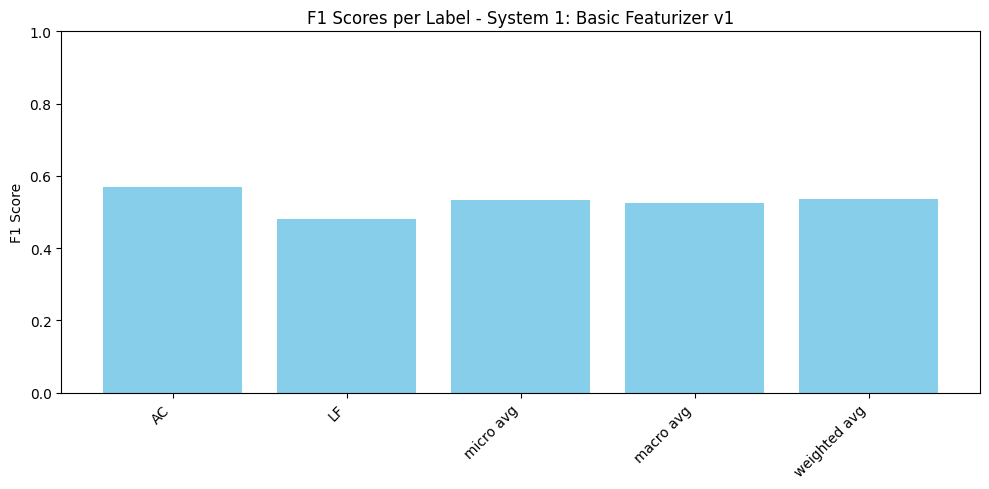


=== Running CRF Pipeline: System 1: Extended Featurizer v2 ===

=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.76      0.78      0.77       508
          LF       0.51      0.41      0.45       306

   micro avg       0.68      0.64      0.66       814
   macro avg       0.64      0.59      0.61       814
weighted avg       0.67      0.64      0.65       814


=== Test Set Report ===
{'AC': {'precision': np.float64(0.7370283018867925), 'recall': np.float64(0.7841907151819323), 'f1-score': np.float64(0.7598784194528876), 'support': np.int64(797)}, 'LF': {'precision': np.float64(0.5602094240837696), 'recall': np.float64(0.44398340248962653), 'f1-score': np.float64(0.49537037037037035), 'support': np.int64(482)}, 'micro avg': {'precision': np.float64(0.6821138211382114), 'recall': np.float64(0.6559812353401094), 'f1-score': np.float64(0.6687923475488243), 'support': np.int64(1279)}, 'macro avg': {'precision': np.float64(0.6486188

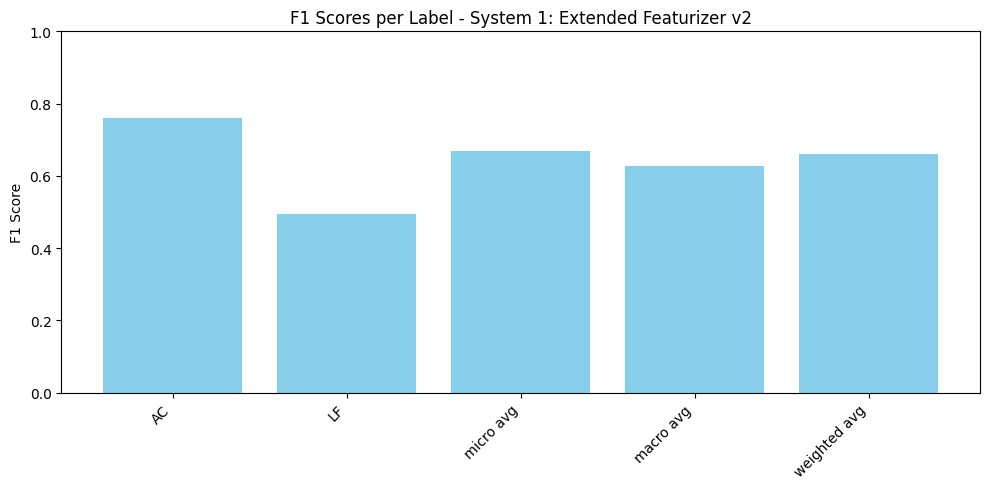

In [6]:
# Variation 1: Basic Features
def basic_featurizer_v1(sent):
    return [{'word': word.lower(), 'suffix3': word[-3:].lower()} for word in sent]

# Variation 2: Extended Features
def basic_featurizer_v2(sent):
    return [{
        'word': word.lower(),
        'prefix3': word[:3].lower(),
        'suffix3': word[-3:].lower(),
        'is_cap': word[0].isupper(),
        'is_no_cap': word[0].islower()
    } for word in sent]

# Initialize model
sys1_crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.01,
    max_iterations=200,
    linesearch='StrongBacktracking',
    all_possible_transitions=True
)

# Run for both feature variations
run_crf_pipeline(basic_featurizer_v1, dataset, sys1_crf, variation_name="System 1: Basic Featurizer v1")
run_crf_pipeline(basic_featurizer_v2, dataset, sys1_crf, variation_name="System 1: Extended Featurizer v2")

# System 2 : CRF with Advanced Features (POS tags, n-grams)

/Users/oguzhantanrikulu/nltk_data/taggers/averaged_perceptron_tagger

=== Running CRF Pipeline: System 2: Advanced Featurizer v1 ===



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/oguzhantanrikulu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/oguzhantanrikulu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.82      0.76      0.79       508
          LF       0.67      0.64      0.65       306

   micro avg       0.76      0.71      0.74       814
   macro avg       0.75      0.70      0.72       814
weighted avg       0.77      0.71      0.74       814


=== Test Set Report ===
{'AC': {'precision': np.float64(0.8453333333333334), 'recall': np.float64(0.795483061480552), 'f1-score': np.float64(0.8196509372979962), 'support': np.int64(797)}, 'LF': {'precision': np.float64(0.7117903930131004), 'recall': np.float64(0.6763485477178424), 'f1-score': np.float64(0.6936170212765957), 'support': np.int64(482)}, 'micro avg': {'precision': np.float64(0.7947019867549668), 'recall': np.float64(0.7505863956215794), 'f1-score': np.float64(0.7720144752714114), 'support': np.int64(1279)}, 'macro avg': {'precision': np.float64(0.778561863173217), 'recall': np.float64(0.7359158045991971), 'f1-score': np.

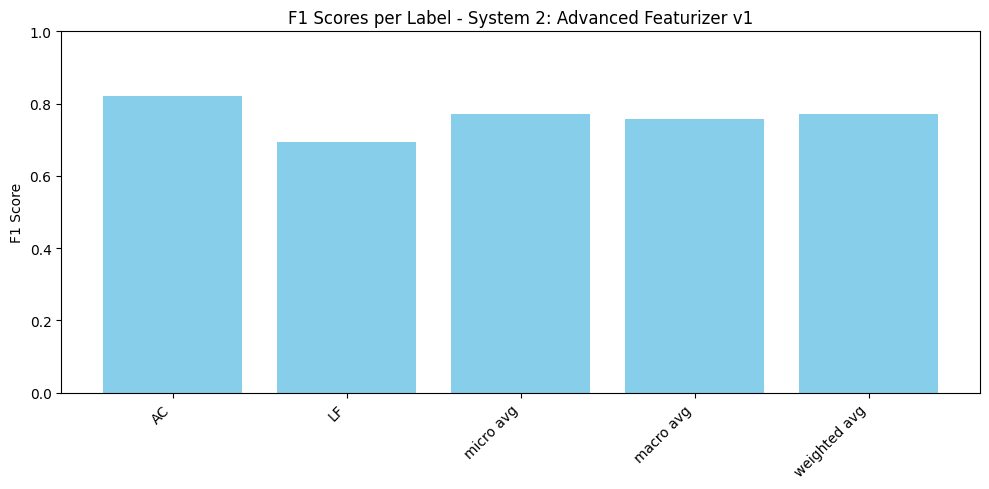

In [7]:
import nltk
from nltk.util import ngrams
from nltk.stem import PorterStemmer
from nltk import pos_tag

# Download required NLTK resources
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

print(nltk.data.find('taggers/averaged_perceptron_tagger'))

# Initialize stemmer
stemmer = PorterStemmer()

def extract_common_features(sent, i, bigrams, trigrams):
    """
    Extract common features for a given word in a sentence.

    :param sent: List of words in the sentence.
    :param i: Index of the current word.
    :param bigrams: List of bigrams for the sentence.
    :param trigrams: List of trigrams for the sentence.
    :return: Dictionary of common features.
    """
    word = sent[i]

    # Get surrounding words
    prev_word = sent[i-1].lower() if i > 0 else '<START>'
    next_word = sent[i+1].lower() if i < len(sent)-1 else '<END>'

    # Get n-grams
    curr_bigram = bigrams[i] if i < len(bigrams) else ('<END>', '<END>')
    curr_trigram = trigrams[i] if i < len(trigrams) else ('<END>', '<END>', '<END>')

    features = {
        # Word features
        'word': word.lower(),
        'stem': stemmer.stem(word),
        'length': len(word),

        # N-gram features
        'bigram': f"{curr_bigram[0].lower()}_{curr_bigram[1].lower()}",
        'trigram': f"{curr_trigram[0].lower()}_{curr_trigram[1].lower()}_{curr_trigram[2].lower()}",

        # Context features
        'prev_word': prev_word,
        'next_word': next_word,
        'prev_next': f"{prev_word}_{next_word}",

        # Orthographic features
        'is_cap': word[0].isupper(),
        'is_num': word.isdigit(),
        'has_hyphen': '-' in word,
        'prefix3': word[:3].lower(),
        'suffix3': word[-3:].lower()
    }
    return features

def advanced_featurizer_v1(sent):
    """
    Feature extractor without POS tagging.

    :param sent: List of words in the sentence.
    :return: List of feature dictionaries for each word.
    """
    bigrams = list(ngrams(sent, 2))
    trigrams = list(ngrams(sent, 3))
    features = [extract_common_features(sent, i, bigrams, trigrams) for i in range(len(sent))]
    return features

def advanced_featurizer_v2(sent):
    """
    Feature extractor with POS tagging.

    :param sent: List of words in the sentence.
    :return: List of feature dictionaries for each word.
    """
    pos_tags = pos_tag(sent)
    bigrams = list(ngrams(sent, 2))
    trigrams = list(ngrams(sent, 3))
    features = []
    for i in range(len(sent)):
        feature = extract_common_features(sent, i, bigrams, trigrams)
        # Add POS features
        current_pos = pos_tags[i][1]
        prev_pos = pos_tags[i-1][1] if i > 0 else '<START_POS>'
        next_pos = pos_tags[i+1][1] if i < len(sent)-1 else '<END_POS>'
        feature.update({
            'pos': current_pos,
            'prev_pos': prev_pos,
            'next_pos': next_pos,
            'pos_trigram': f"{prev_pos}_{current_pos}_{next_pos}",
        })
        features.append(feature)
    return features

# Initialize model
sys2_crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.01,
    max_iterations=200,
    linesearch='StrongBacktracking',
    all_possible_transitions=True
)

# Run for both feature variations
run_crf_pipeline(advanced_featurizer_v1, dataset, sys1_crf, variation_name="System 2: Advanced Featurizer v1")
# run_crf_pipeline(advanced_featurizer_v2, dataset, sys1_crf, variation_name="System 2: Advanced Featurizer v1")


=== Running CRF Pipeline: System 2: Advanced Featurizer v2 ===

=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.82      0.81      0.82       508
          LF       0.63      0.65      0.64       306

   micro avg       0.75      0.75      0.75       814
   macro avg       0.73      0.73      0.73       814
weighted avg       0.75      0.75      0.75       814


=== Test Set Report ===
{'AC': {'precision': np.float64(0.8343711083437111), 'recall': np.float64(0.8406524466750314), 'f1-score': np.float64(0.8375), 'support': np.int64(797)}, 'LF': {'precision': np.float64(0.7085106382978723), 'recall': np.float64(0.6908713692946058), 'f1-score': np.float64(0.6995798319327732), 'support': np.int64(482)}, 'micro avg': {'precision': np.float64(0.7879025923016496), 'recall': np.float64(0.784206411258796), 'f1-score': np.float64(0.7860501567398119), 'support': np.int64(1279)}, 'macro avg': {'precision': np.float64(0.7714408733207917), 're

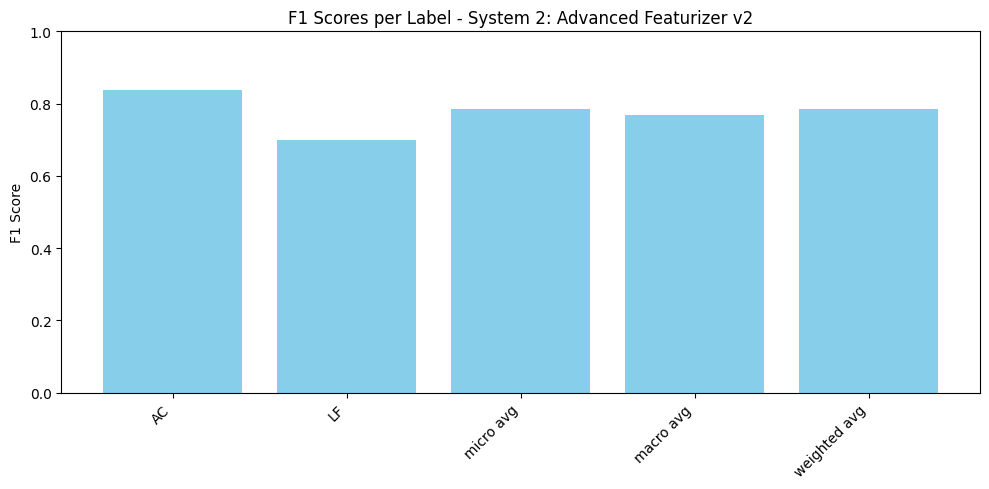

In [8]:
run_crf_pipeline(advanced_featurizer_v2, dataset, sys1_crf, variation_name="System 2: Advanced Featurizer v2")

# System 3: BERT + FFNN


## System A: CRF with Advanced Features


=== Running CRF Pipeline: System A: CRF Advanced ===

=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.82      0.81      0.82       508
          LF       0.63      0.65      0.64       306

   micro avg       0.75      0.75      0.75       814
   macro avg       0.73      0.73      0.73       814
weighted avg       0.75      0.75      0.75       814


=== Test Set Report ===
{'AC': {'precision': np.float64(0.8343711083437111), 'recall': np.float64(0.8406524466750314), 'f1-score': np.float64(0.8375), 'support': np.int64(797)}, 'LF': {'precision': np.float64(0.7085106382978723), 'recall': np.float64(0.6908713692946058), 'f1-score': np.float64(0.6995798319327732), 'support': np.int64(482)}, 'micro avg': {'precision': np.float64(0.7879025923016496), 'recall': np.float64(0.784206411258796), 'f1-score': np.float64(0.7860501567398119), 'support': np.int64(1279)}, 'macro avg': {'precision': np.

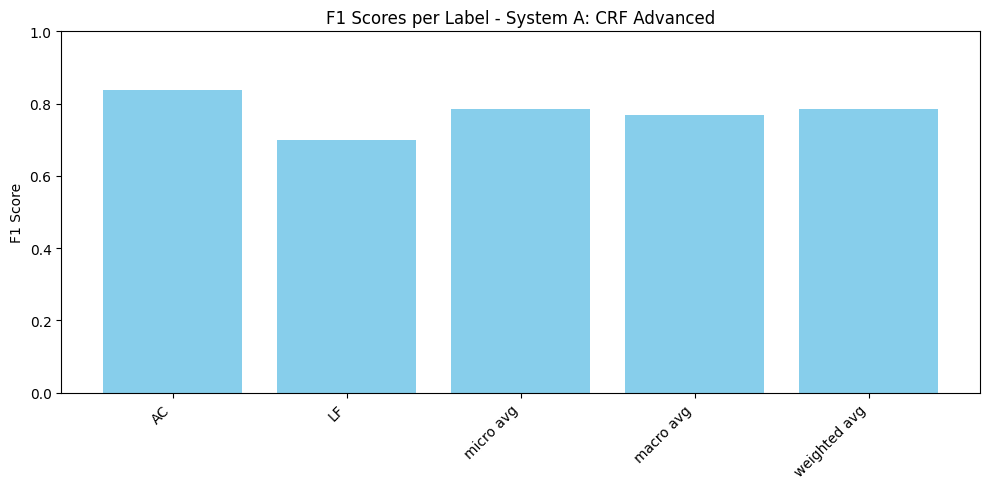

In [9]:
# 2.2 Architect Experiment

# --- System A: CRF with Advanced Features ---
from sklearn_crfsuite import CRF

print("\n## System A: CRF with Advanced Features\n")
sysA_crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.01,
    max_iterations=200,
    all_possible_transitions=True
)
run_crf_pipeline(advanced_featurizer_v2, dataset, sysA_crf, variation_name="System A: CRF Advanced")


In [10]:
# --- Shared setup for Systems B1–B5: vectorize advanced features ---
# Define the run_sklearn_pipeline function
def run_sklearn_pipeline(X_train, y_train_flat, X_val, y_val_nested, val_lengths, X_test, y_test_nested, test_lengths,
                         model, model_name="Unnamed Sklearn Model"):
    print(f"\n=== Running Sklearn Pipeline: {model_name} ===")

    # Train model
    print(f"Training {model_name} model...")
    start_time = time.time()
    model.fit(X_train, y_train_flat)
    end_time = time.time()
    print(f"Training finished in {end_time - start_time:.2f} seconds.")

    # Predict on validation set
    print("\nPredicting on validation set...")
    start_time = time.time()
    y_val_pred_flat = model.predict(X_val)
    end_time = time.time()
    print(f"Prediction finished in {end_time - start_time:.2f} seconds.")

    # Reshape flat predictions back into sequences for seqeval
    y_val_pred_nested = []
    current_idx = 0
    for length in val_lengths:
        y_val_pred_nested.append(list(y_val_pred_flat[current_idx: current_idx + length]))
        current_idx += length

    # Evaluate on validation set
    print("\n=== Validation Set Report ===")
    print(classification_report(y_val_nested, y_val_pred_nested))

    # Predict on test set
    print("\nPredicting on test set...")
    start_time = time.time()
    y_test_pred_flat = model.predict(X_test)
    end_time = time.time()
    print(f"Prediction finished in {end_time - start_time:.2f} seconds.")

    # Reshape flat predictions back into sequences for seqeval
    y_test_pred_nested = []
    current_idx = 0
    for length in test_lengths:
        y_test_pred_nested.append(list(y_test_pred_flat[current_idx: current_idx + length]))
        current_idx += length

    # Evaluate on test set
    print("\n=== Test Set Report ===")
    report_test = classification_report(y_test_nested, y_test_pred_nested, output_dict=True)
    print(classification_report(y_test_nested, y_test_pred_nested))  # Print human-readable report

    # Plot F1-scores for each label
    plot_f1_scores(report_test, model_name)

    return report_test  # Return the report dictionary

In [11]:
from sklearn.feature_extraction import DictVectorizer

def vectorize_features(train_feats, val_feats, test_feats):
    # flatten
    X_tr_flat = [f for sent in train_feats for f in sent]
    X_val_flat = [f for sent in val_feats   for f in sent]
    X_te_flat = [f for sent in test_feats  for f in sent]
    vec = DictVectorizer(sparse=True)
    X_tr = vec.fit_transform(X_tr_flat)
    X_val = vec.transform(X_val_flat)
    X_te = vec.transform(X_te_flat)
    return X_tr, X_val, X_te

def flatten_labels(sequences):
    return [tag for seq in sequences for tag in seq]

# prepare advanced features
train_feats_A = [advanced_featurizer_v2(s) for s in train_tokens]
val_feats_A   = [advanced_featurizer_v2(s) for s in val_tokens]
test_feats_A  = [advanced_featurizer_v2(s) for s in test_tokens]

X_train_vec, X_val_vec, X_test_vec = vectorize_features(train_feats_A, val_feats_A, test_feats_A)
y_train_flat = flatten_labels(train_tags)
val_lengths  = [len(s) for s in val_tokens]
test_lengths = [len(s) for s in test_tokens]


In [12]:
# prepare advanced features
train_feats_A = [advanced_featurizer_v2(s) for s in train_tokens]
val_feats_A   = [advanced_featurizer_v2(s) for s in val_tokens]
test_feats_A  = [advanced_featurizer_v2(s) for s in test_tokens]

X_train_vec, X_val_vec, X_test_vec = vectorize_features(train_feats_A, val_feats_A, test_feats_A)
y_train_flat = flatten_labels(train_tags)
val_lengths  = [len(s) for s in val_tokens]
test_lengths = [len(s) for s in test_tokens]


=== Running Sklearn Pipeline: B1: Logistic Regression ===
Training B1: Logistic Regression model...
Training finished in 5.85 seconds.

Predicting on validation set...
Prediction finished in 0.00 seconds.

=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.82      0.79      0.80       508
          LF       0.26      0.40      0.31       306

   micro avg       0.54      0.64      0.59       814
   macro avg       0.54      0.59      0.56       814
weighted avg       0.61      0.64      0.62       814


Predicting on test set...
Prediction finished in 0.00 seconds.

=== Test Set Report ===
              precision    recall  f1-score   support

          AC       0.84      0.83      0.83       797
          LF       0.25      0.39      0.31       482

   micro avg       0.55      0.66      0.60      1279
   macro avg       0.54      0.61      0.57      1279
weighted avg       0.62      0.66      0.63      1279



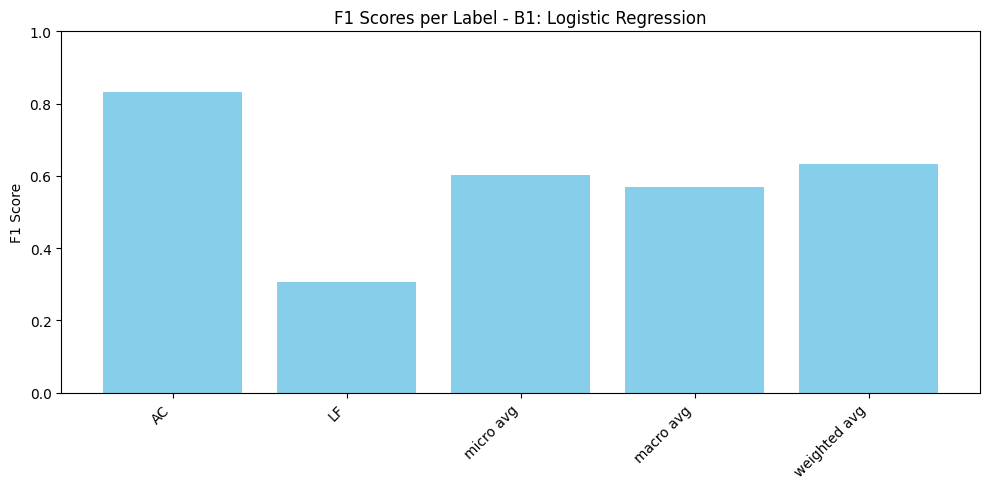


=== Running Sklearn Pipeline: B2: Multinomial Naive Bayes ===
Training B2: Multinomial Naive Bayes model...
Training finished in 0.04 seconds.

Predicting on validation set...
Prediction finished in 0.00 seconds.

=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.83      0.73      0.78       508
          LF       0.17      0.24      0.20       306

   micro avg       0.50      0.55      0.53       814
   macro avg       0.50      0.49      0.49       814
weighted avg       0.58      0.55      0.56       814


Predicting on test set...
Prediction finished in 0.00 seconds.

=== Test Set Report ===
              precision    recall  f1-score   support

          AC       0.83      0.75      0.79       797
          LF       0.14      0.22      0.17       482

   micro avg       0.48      0.55      0.51      1279
   macro avg       0.48      0.48      0.48      1279
weighted avg       0.57      0.55      0.56      1279



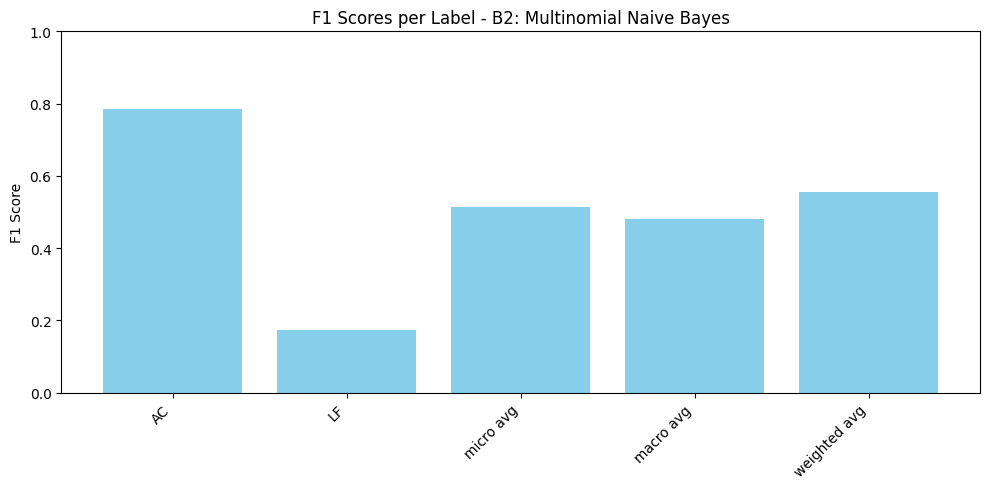


=== Running Sklearn Pipeline: B3: Linear SVC ===
Training B3: Linear SVC model...


/Users/oguzhantanrikulu/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training finished in 32.53 seconds.

Predicting on validation set...
Prediction finished in 0.00 seconds.

=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.82      0.81      0.81       508
          LF       0.28      0.44      0.34       306

   micro avg       0.55      0.67      0.61       814
   macro avg       0.55      0.62      0.58       814
weighted avg       0.62      0.67      0.64       814


Predicting on test set...
Prediction finished in 0.00 seconds.

=== Test Set Report ===
              precision    recall  f1-score   support

          AC       0.83      0.83      0.83       797
          LF       0.28      0.44      0.34       482

   micro avg       0.56      0.68      0.61      1279
   macro avg       0.55      0.63      0.58      1279
weighted avg       0.62      0.68      0.64      1279



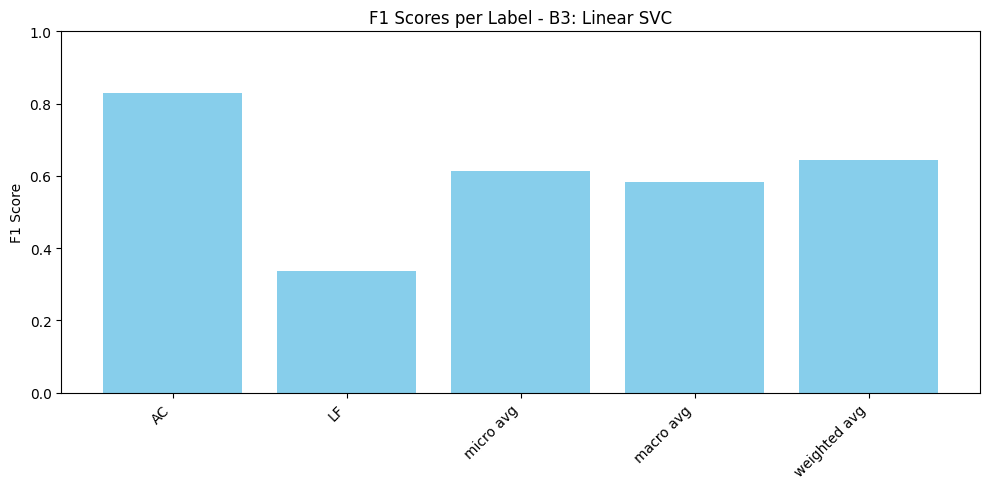


=== Running Sklearn Pipeline: B4: Decision Tree ===
Training B4: Decision Tree model...
Training finished in 21.87 seconds.

Predicting on validation set...
Prediction finished in 0.00 seconds.

=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.80      0.76      0.78       508
          LF       0.18      0.33      0.24       306

   micro avg       0.47      0.59      0.53       814
   macro avg       0.49      0.54      0.51       814
weighted avg       0.57      0.59      0.57       814


Predicting on test set...
Prediction finished in 0.01 seconds.

=== Test Set Report ===
              precision    recall  f1-score   support

          AC       0.79      0.81      0.80       797
          LF       0.19      0.34      0.24       482

   micro avg       0.48      0.63      0.55      1279
   macro avg       0.49      0.58      0.52      1279
weighted avg       0.57      0.63      0.59      1279



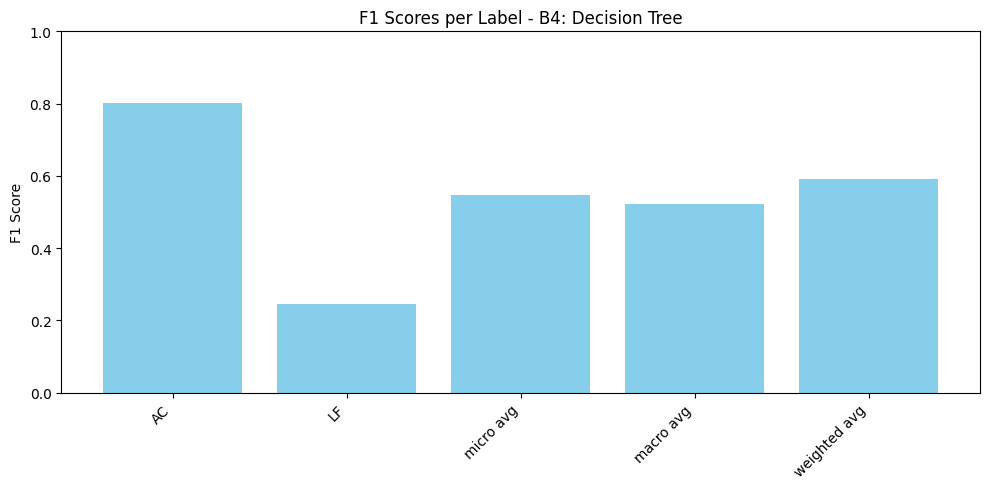


=== Running Sklearn Pipeline: B5: Random Forest ===
Training B5: Random Forest model...
Training finished in 124.28 seconds.

Predicting on validation set...
Prediction finished in 0.11 seconds.

=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.82      0.70      0.75       508
          LF       0.17      0.25      0.20       306

   micro avg       0.50      0.53      0.51       814
   macro avg       0.50      0.47      0.48       814
weighted avg       0.58      0.53      0.55       814


Predicting on test set...
Prediction finished in 0.16 seconds.

=== Test Set Report ===
              precision    recall  f1-score   support

          AC       0.84      0.75      0.79       797
          LF       0.19      0.27      0.22       482

   micro avg       0.53      0.57      0.55      1279
   macro avg       0.52      0.51      0.51      1279
weighted avg       0.60      0.57      0.58      1279



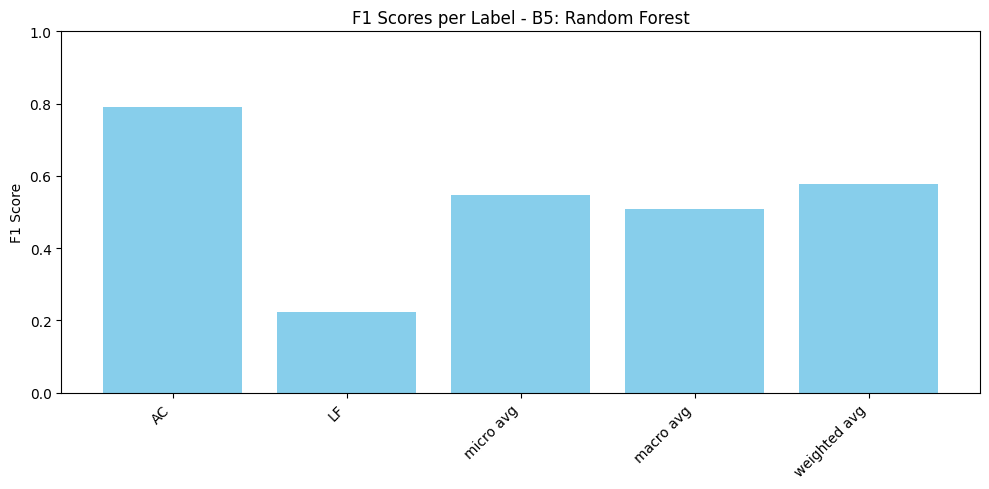

In [13]:

# --- System B: Classical Classifiers on Advanced Features ---
from sklearn.linear_model    import LogisticRegression
from sklearn.naive_bayes     import MultinomialNB
from sklearn.svm             import LinearSVC
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier

classifiers = {
    "B1: Logistic Regression"    : LogisticRegression(max_iter=200, solver='liblinear', random_state=42),
    "B2: Multinomial Naive Bayes": MultinomialNB(),
    "B3: Linear SVC"             : LinearSVC(max_iter=5000, random_state=42),
    "B4: Decision Tree"          : DecisionTreeClassifier(random_state=42),
    "B5: Random Forest"          : RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

for name, model in classifiers.items():
    _ = run_sklearn_pipeline(
        X_train_vec, y_train_flat,
        X_val_vec, val_tags,       val_lengths,
        X_test_vec, test_tags,     test_lengths,
        model, model_name=name
    )


Vocabulary size (Token2Idx): 14724
Tagset size (Tag2Idx): 5
Using device for PyTorch model: cpu

## System C: BiLSTM + Linear Layer Model

Epoch 1/10 | Train Loss: 0.7246

=== System C Epoch 1 Val Report ===
              precision    recall  f1-score   support

          AC       0.81      0.48      0.60       508
          LF       0.28      0.26      0.27       306

   micro avg       0.55      0.40      0.46       814
   macro avg       0.54      0.37      0.44       814
weighted avg       0.61      0.40      0.48       814



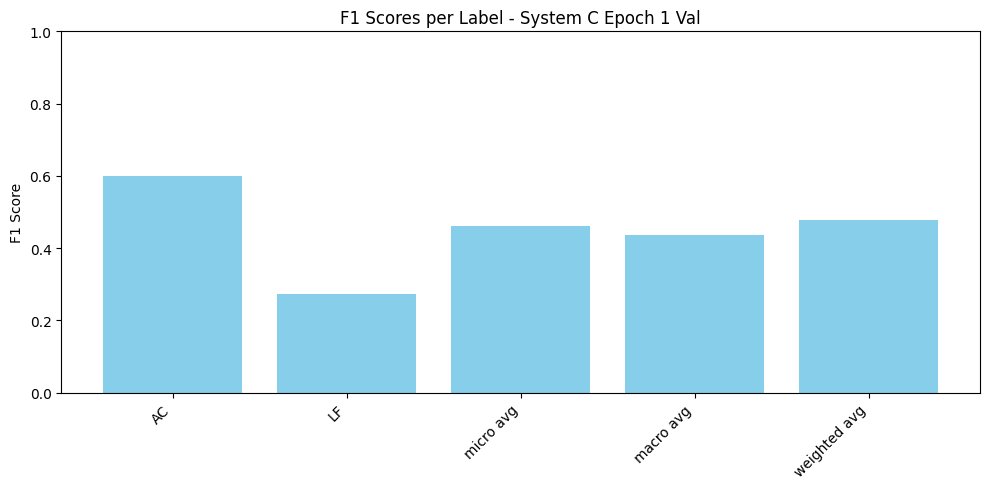

New best validation F1: 0.4767. Saving model.
Epoch 2/10 | Train Loss: 0.4572

=== System C Epoch 2 Val Report ===
              precision    recall  f1-score   support

          AC       0.77      0.57      0.66       508
          LF       0.44      0.57      0.50       306

   micro avg       0.60      0.57      0.59       814
   macro avg       0.61      0.57      0.58       814
weighted avg       0.65      0.57      0.60       814



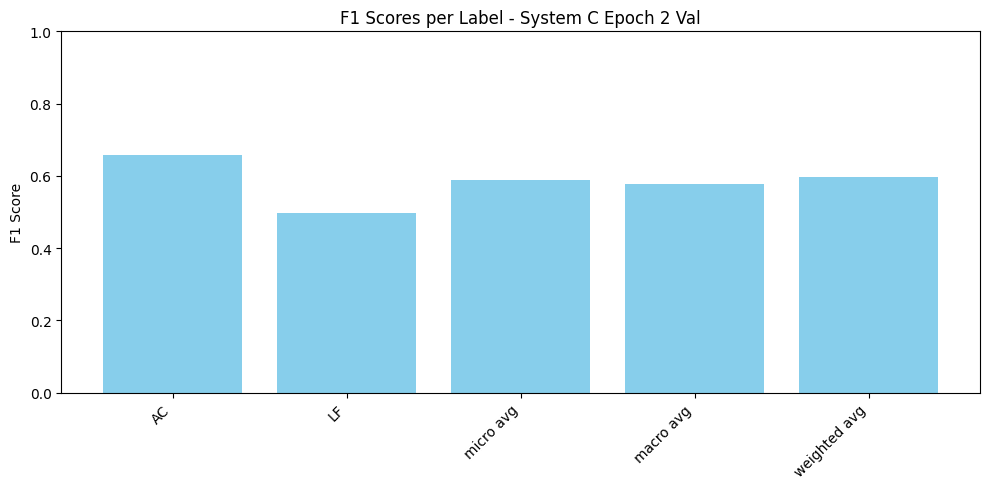

New best validation F1: 0.5978. Saving model.
Epoch 3/10 | Train Loss: 0.3849

=== System C Epoch 3 Val Report ===
              precision    recall  f1-score   support

          AC       0.78      0.58      0.67       508
          LF       0.45      0.52      0.48       306

   micro avg       0.62      0.56      0.59       814
   macro avg       0.62      0.55      0.57       814
weighted avg       0.66      0.56      0.60       814



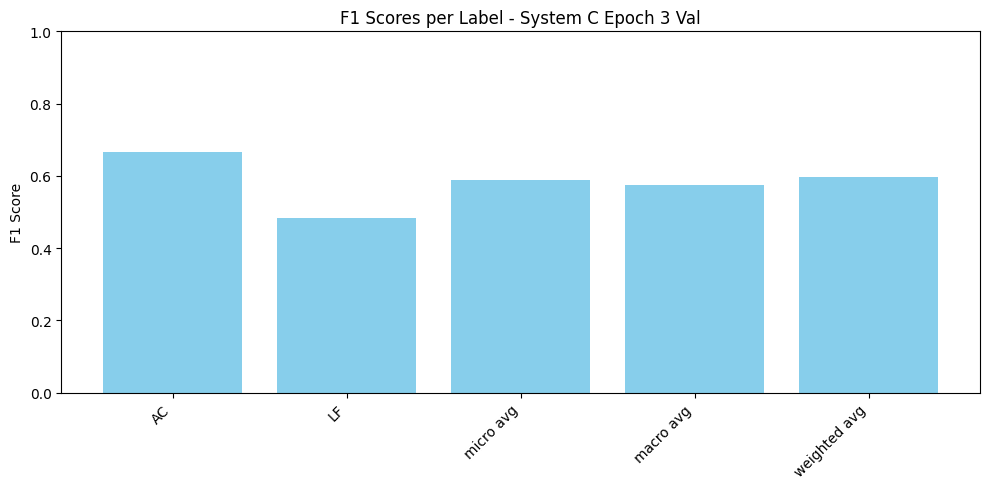

Validation F1 did not improve. Current: 0.5971, Best: 0.5978
Epoch 4/10 | Train Loss: 0.3560

=== System C Epoch 4 Val Report ===
              precision    recall  f1-score   support

          AC       0.79      0.59      0.68       508
          LF       0.51      0.59      0.55       306

   micro avg       0.66      0.59      0.62       814
   macro avg       0.65      0.59      0.61       814
weighted avg       0.69      0.59      0.63       814



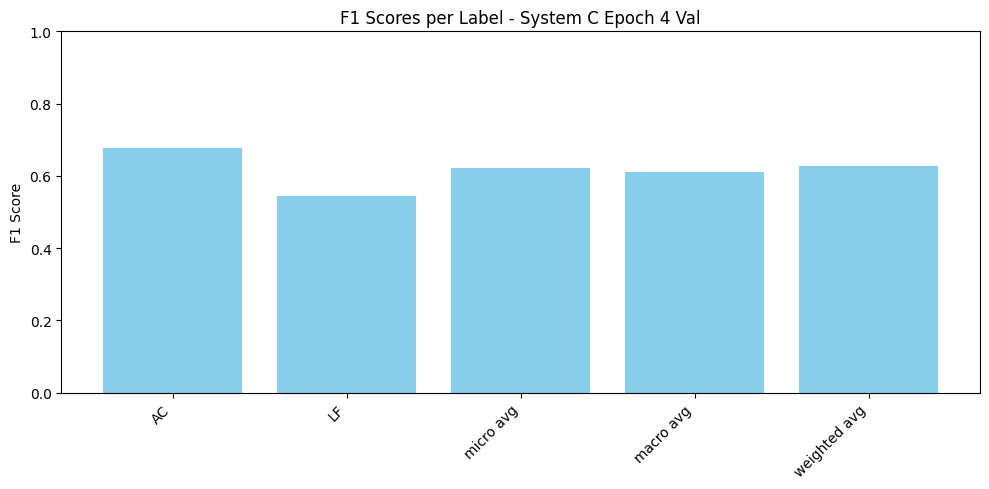

New best validation F1: 0.6277. Saving model.
Epoch 5/10 | Train Loss: 0.3257

=== System C Epoch 5 Val Report ===
              precision    recall  f1-score   support

          AC       0.78      0.62      0.69       508
          LF       0.52      0.65      0.58       306

   micro avg       0.65      0.63      0.64       814
   macro avg       0.65      0.63      0.63       814
weighted avg       0.68      0.63      0.65       814



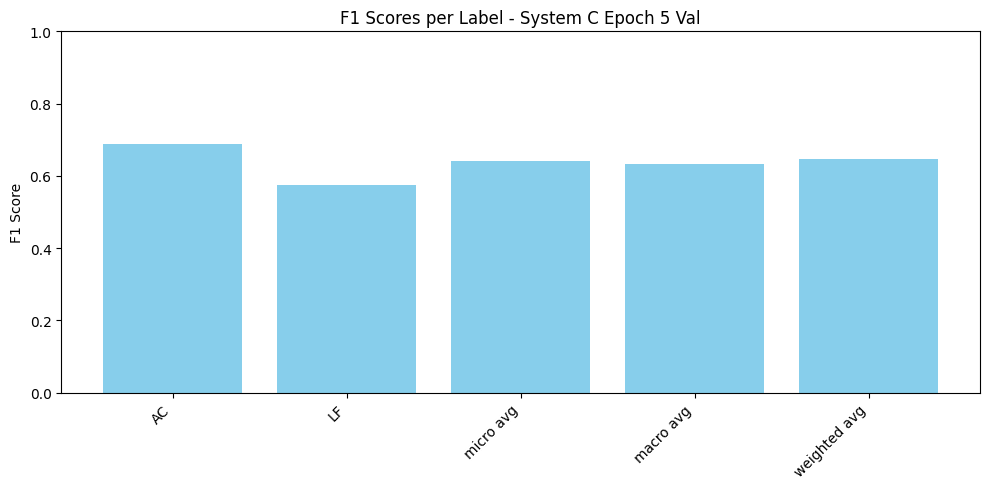

New best validation F1: 0.6461. Saving model.
Epoch 6/10 | Train Loss: 0.3022

=== System C Epoch 6 Val Report ===
              precision    recall  f1-score   support

          AC       0.77      0.63      0.70       508
          LF       0.54      0.66      0.59       306

   micro avg       0.66      0.64      0.65       814
   macro avg       0.66      0.65      0.64       814
weighted avg       0.68      0.64      0.66       814



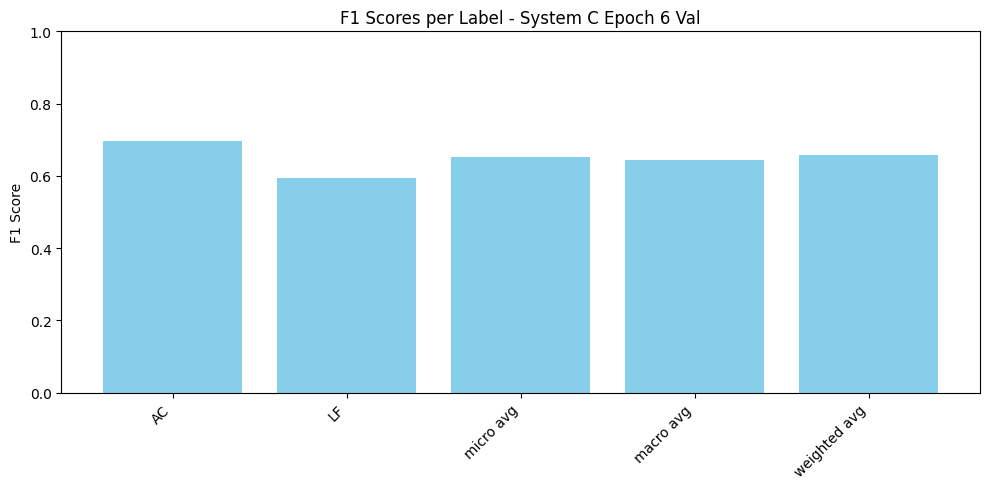

New best validation F1: 0.6572. Saving model.
Epoch 7/10 | Train Loss: 0.2855

=== System C Epoch 7 Val Report ===
              precision    recall  f1-score   support

          AC       0.78      0.63      0.70       508
          LF       0.55      0.68      0.60       306

   micro avg       0.67      0.65      0.66       814
   macro avg       0.66      0.65      0.65       814
weighted avg       0.69      0.65      0.66       814



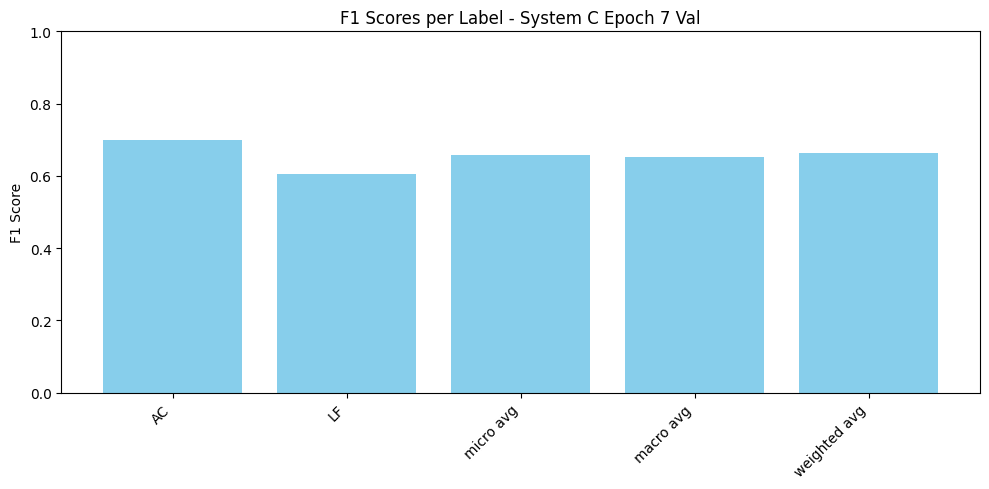

New best validation F1: 0.6628. Saving model.
Epoch 8/10 | Train Loss: 0.2652

=== System C Epoch 8 Val Report ===
              precision    recall  f1-score   support

          AC       0.76      0.64      0.69       508
          LF       0.53      0.65      0.58       306

   micro avg       0.65      0.64      0.64       814
   macro avg       0.64      0.64      0.64       814
weighted avg       0.67      0.64      0.65       814



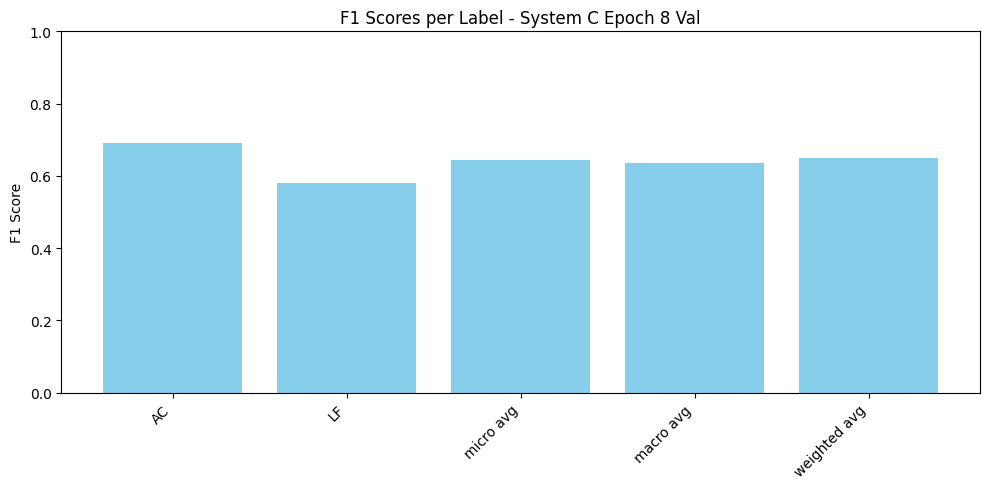

Validation F1 did not improve. Current: 0.6500, Best: 0.6628
Epoch 9/10 | Train Loss: 0.2453

=== System C Epoch 9 Val Report ===
              precision    recall  f1-score   support

          AC       0.75      0.65      0.69       508
          LF       0.53      0.68      0.59       306

   micro avg       0.64      0.66      0.65       814
   macro avg       0.64      0.67      0.64       814
weighted avg       0.66      0.66      0.66       814



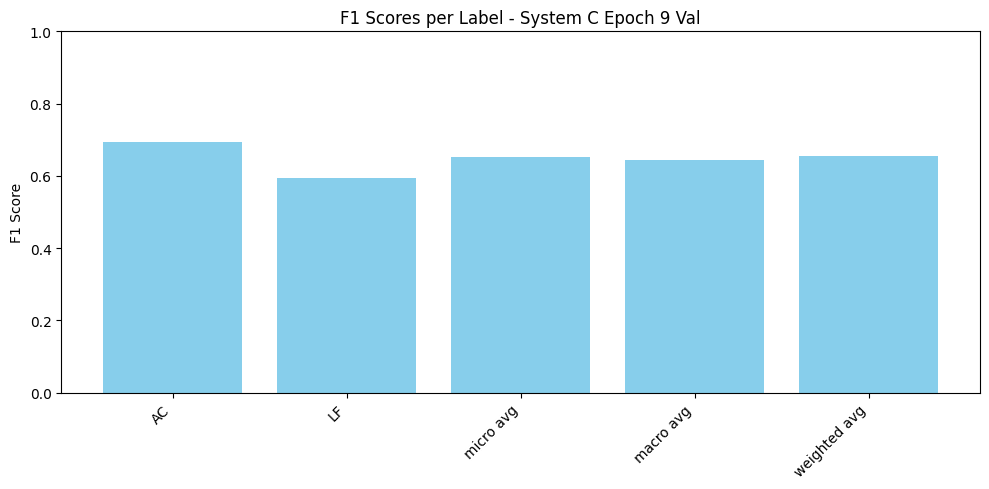

Validation F1 did not improve. Current: 0.6562, Best: 0.6628
Epoch 10/10 | Train Loss: 0.2289

=== System C Epoch 10 Val Report ===
              precision    recall  f1-score   support

          AC       0.74      0.65      0.69       508
          LF       0.53      0.68      0.59       306

   micro avg       0.64      0.66      0.65       814
   macro avg       0.63      0.67      0.64       814
weighted avg       0.66      0.66      0.66       814



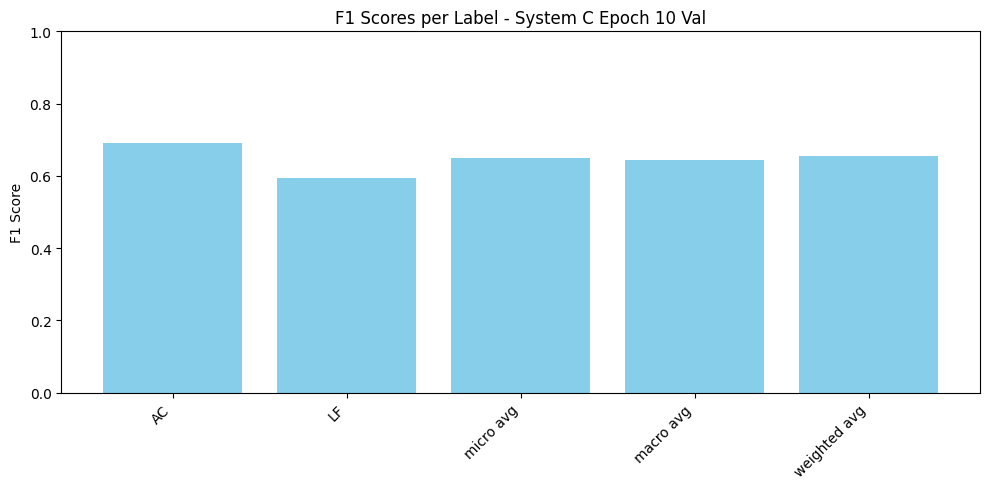

Validation F1 did not improve. Current: 0.6552, Best: 0.6628
Early stopping triggered after 10 epochs.

--- Final Evaluation on Test Set (System C) ---

=== System C Test Report ===
              precision    recall  f1-score   support

          AC       0.79      0.70      0.74       797
          LF       0.58      0.69      0.63       482

   micro avg       0.69      0.70      0.69      1279
   macro avg       0.68      0.70      0.68      1279
weighted avg       0.71      0.70      0.70      1279



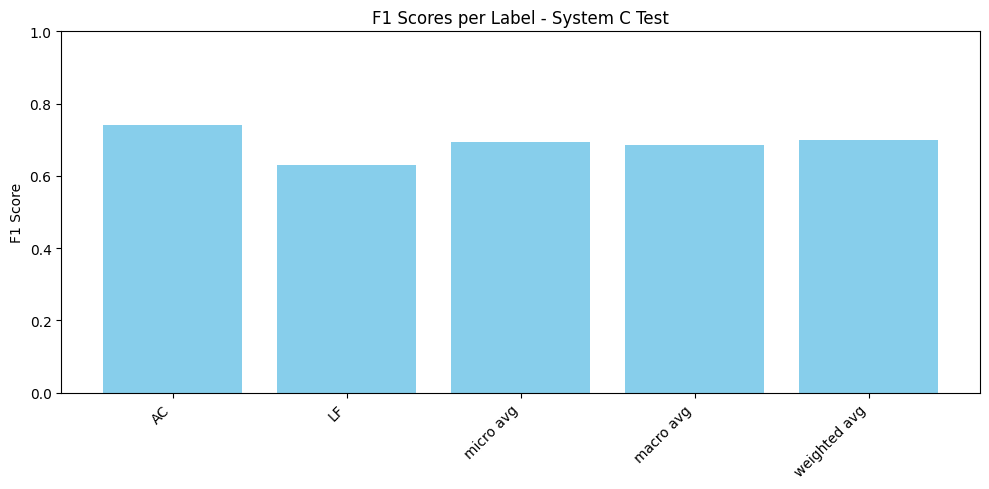



=== All Experiments Concluded ===


In [14]:
# --- System C: BiLSTM-CRF Model ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# --- Prepare Data for PyTorch Model (System C) ---
# Collecting all unique tokens and tags from all splits for consistent mapping
all_tokens_flat = [token.lower() for sent in train_tokens + val_tokens + test_tokens for token in sent]

all_tags_flat = [str(tag) for sent_tags in train_tags + val_tags + test_tags for tag in sent_tags]

# Creating token and tag mappings
# Vocab: <PAD>, <UNK> + unique tokens
unique_tokens_sorted = sorted(list(set(all_tokens_flat)))
token2idx = {"<PAD>": 0, "<UNK>": 1}
for i, token in enumerate(unique_tokens_sorted):
    token2idx[token] = i + 2 # Start from 2 due to PAD and UNK
idx2token = {idx: token for token, idx in token2idx.items()}

# Tagset: <PAD_TAG> + unique tags
unique_tags_sorted = sorted(list(set(all_tags_flat)))
tag2idx = {"<PAD_TAG>": 0} # PAD_TAG for padding, distinct from actual tags
for i, tag in enumerate(unique_tags_sorted):
    tag2idx[tag] = i + 1 # Start from 1
idx2tag = {idx: tag for tag, idx in tag2idx.items()}


print(f"\nVocabulary size (Token2Idx): {len(token2idx)}")
print(f"Tagset size (Tag2Idx): {len(tag2idx)}")
# print("Sample Token2Idx:", list(token2idx.items())[:10])
# print("Sample Tag2Idx:", list(tag2idx.items()))


class NERDatasetPyTorch(Dataset):
    def __init__(self, list_of_token_sequences, list_of_tag_sequences, local_token2idx, local_tag2idx):
        self.token_sequences = list_of_token_sequences
        self.tag_sequences = list_of_tag_sequences
        self.token2idx = local_token2idx
        self.tag2idx = local_tag2idx
        self.unk_token_idx = self.token2idx["<UNK>"]

    def __len__(self):
        return len(self.token_sequences)

    def __getitem__(self, idx):
        token_seq = self.token_sequences[idx]
        tag_seq = self.tag_sequences[idx]

        # Converting tokens and tags to indices
        token_indices = [self.token2idx.get(token.lower(), self.unk_token_idx) for token in token_seq]
        tag_indices = [self.tag2idx[str(tag)] for tag in tag_seq]

        return torch.tensor(token_indices, dtype=torch.long), torch.tensor(tag_indices, dtype=torch.long)


def collate_fn_pytorch(batch, local_token2idx, local_tag2idx):
    tokens_batch, tags_batch = zip(*batch)
    # Pad sequences
    tokens_padded = pad_sequence(tokens_batch, batch_first=True, padding_value=local_token2idx["<PAD>"])
    tags_padded = pad_sequence(tags_batch, batch_first=True, padding_value=local_tag2idx["<PAD_TAG>"])
    return tokens_padded, tags_padded


# Creating datasets and dataloaders for PyTorch model
BATCH_SIZE_PYTORCH = 32 # Renamed for clarity
train_dataset_pytorch = NERDatasetPyTorch(train_tokens, train_tags, token2idx, tag2idx)
val_dataset_pytorch = NERDatasetPyTorch(val_tokens, val_tags, token2idx, tag2idx)
test_dataset_pytorch = NERDatasetPyTorch(test_tokens, test_tags, token2idx, tag2idx)

# Lambda to pass token2idx and tag2idx to collate_fn
collate_with_mappings = lambda batch: collate_fn_pytorch(batch, token2idx, tag2idx)

train_loader_pytorch = DataLoader(train_dataset_pytorch, batch_size=BATCH_SIZE_PYTORCH, shuffle=True, collate_fn=collate_with_mappings)
val_loader_pytorch = DataLoader(val_dataset_pytorch, batch_size=BATCH_SIZE_PYTORCH, shuffle=False, collate_fn=collate_with_mappings)
test_loader_pytorch = DataLoader(test_dataset_pytorch, batch_size=BATCH_SIZE_PYTORCH, shuffle=False, collate_fn=collate_with_mappings)


class BiLSTM_SeqTag(nn.Module): # Renaming for clarity (not a CRF)
    def __init__(self, vocab_size, tagset_size, emb_dim=100, hid_dim=256, lstm_layers=1, dropout_rate=0.3, local_token2idx_pad_idx=0):
        super().__init__()
        self.embedding_dim = emb_dim
        self.hidden_dim = hid_dim
        self.vocab_size = vocab_size
        self.tagset_size = tagset_size

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=local_token2idx_pad_idx)
        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=lstm_layers,
                            bidirectional=True, batch_first=True, dropout=dropout_rate if lstm_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden2tag = nn.Linear(hid_dim * 2, tagset_size) # *2 for bidirectional

    def forward(self, sentences):
        # sentences: (batch, seq_len)
        embeds = self.embedding(sentences)  # embeds: (batch, seq_len, emb_dim)
        embeds = self.dropout(embeds)

        lstm_out, _ = self.lstm(embeds)  # lstm_out: (batch, seq_len, hid_dim*2)
        lstm_out = self.dropout(lstm_out)

        tag_space = self.hidden2tag(lstm_out)  # tag_space: (batch, seq_len, tagset_size)
        # if CrossEntropyLoss: tag_scores = F.log_softmax(tag_space, dim=2)
        return tag_space


# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for PyTorch model: {device}")

# Model instantiation
VOCAB_SIZE = len(token2idx)
TAGSET_SIZE = len(tag2idx)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
LSTM_LAYERS = 1 # Can be increased
DROPOUT = 0.4

modelC = BiLSTM_SeqTag(VOCAB_SIZE, TAGSET_SIZE, EMBEDDING_DIM, HIDDEN_DIM, LSTM_LAYERS, DROPOUT, token2idx["<PAD>"]).to(device)
optimizerC = torch.optim.AdamW(modelC.parameters(), lr=1e-3, weight_decay=1e-5)
# Use ignore_index for the <PAD_TAG>
criterionC = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD_TAG>"])


def train_epoch_pytorch(model, loader, optimizer, criterion, current_device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(current_device), y_batch.to(current_device)
        optimizer.zero_grad()
        logits = model(x_batch)  # (batch, seq_len, tagset_size)

        # if CrossEntropyLoss: (N*seq_len, C) and (N*seq_len)
        loss = criterion(
            logits.view(-1, logits.shape[-1]),
            y_batch.view(-1)
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient clipping
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def evaluate_pytorch_model(model, loader, eval_name, local_idx2tag, local_tag2idx_pad_idx, current_device):
    model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(current_device), y_batch.to(current_device)
            logits = model(x_batch)  # (batch, seq_len, tagset_size)
            predictions = logits.argmax(dim=-1)  # (batch, seq_len)

            # Iterate over each sequence in the batch
            for i in range(y_batch.size(0)):
                true_seq = y_batch[i]
                pred_seq = predictions[i]

                # Filter out PAD tokens based on true labels
                actual_length = (true_seq != local_tag2idx_pad_idx).sum().item()
                true_tags_no_pad = [local_idx2tag[idx.item()] for idx in true_seq[:actual_length]]
                pred_tags_no_pad = [local_idx2tag[idx.item()] for idx in pred_seq[:actual_length]]

                all_true_labels.append(true_tags_no_pad)
                all_predictions.append(pred_tags_no_pad)

    if not all_true_labels or not all_predictions:
        print(f"\n=== {eval_name} Report ===")
        print("No non-PAD sequences to evaluate.")
        return {}

    report_dict_eval = classification_report(all_true_labels, all_predictions, output_dict=True, zero_division=0)
    print(f"\n=== {eval_name} Report ===")
    print(classification_report(all_true_labels, all_predictions, zero_division=0))
    plot_f1_scores(report_dict_eval, eval_name) # Assuming plot_f1_scores is defined
    return report_dict_eval


print("\n## System C: BiLSTM + Linear Layer Model\n")
NUM_EPOCHS_PYTORCH = 10  # Increased epochs, adjust as needed
best_val_f1 = 0
patience = 3
epochs_no_improve = 0

for epoch in range(1, NUM_EPOCHS_PYTORCH + 1):
    train_loss = train_epoch_pytorch(modelC, train_loader_pytorch, optimizerC, criterionC, device)
    print(f"Epoch {epoch}/{NUM_EPOCHS_PYTORCH} | Train Loss: {train_loss:.4f}")

    # Evaluate on validation set
    val_report = evaluate_pytorch_model(modelC, val_loader_pytorch, f"System C Epoch {epoch} Val", idx2tag, tag2idx["<PAD_TAG>"], device)
    current_val_f1 = val_report.get('weighted avg', {}).get('f1-score', 0) # Using weighted F1 for early stopping

    if current_val_f1 > best_val_f1:
        best_val_f1 = current_val_f1
        epochs_no_improve = 0
        print(f"New best validation F1: {best_val_f1:.4f}. Saving model.")
    else:
        epochs_no_improve += 1
        print(f"Validation F1 did not improve. Current: {current_val_f1:.4f}, Best: {best_val_f1:.4f}")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch} epochs.")
        break



# Final test evaluation using the last epoch's model
print("\n--- Final Evaluation on Test Set (System C) ---")
reportC_test = evaluate_pytorch_model(modelC, test_loader_pytorch, "System C Test", idx2tag, tag2idx["<PAD_TAG>"], device)

print("\n\n=== All Experiments Concluded ===")

In [15]:
'''# --- System C: BiLSTM-CRF Model ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from seqeval.metrics import classification_report

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, emb_dim=100, hid_dim=128):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=token2idx["[PAD]"])
        self.lstm = nn.LSTM(emb_dim, hid_dim, bidirectional=True, batch_first=True)
        self.fc   = nn.Linear(hid_dim*2, tagset_size)
        # (you can plug in a CRF layer here if you wish)

    def forward(self, x):
        emb, _ = self.lstm(self.emb(x))
        return self.fc(emb)  # (batch, seq_len, tagset_size)

modelC    = BiLSTM_CRF(len(token2idx), len(tag2idx))
optimizer = torch.optim.AdamW(modelC.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["PAD"])

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(
            logits.view(-1, logits.shape[-1]),
            y_batch.view(-1)
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_and_plot(model, loader, name):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            logits = model(x_batch)
            y_pred = logits.argmax(-1)
            for pred_seq, true_seq in zip(y_pred, y_batch):
                # convert indices → tags, filtering PAD
                p = [idx2tag[i.item()] for (i, t) in zip(pred_seq, true_seq) if t.item() != tag2idx["PAD"]]
                t = [idx2tag[t.item()] for t in true_seq if t.item() != tag2idx["PAD"]]
                preds.append(p)
                trues.append(t)
    # get seqeval report dict
    report_dict = classification_report(trues, preds, output_dict=True, zero_division=0)
    # print the human‐readable report
    print(f"\n=== {name} Report ===")
    print(classification_report(trues, preds, zero_division=0))
    # plot F1 per label
    plot_f1_scores(report_dict, name)
    return report_dict


print("\n## System C: BiLSTM-CRF Model\n")
for epoch in range(1, 4):
    loss = train_epoch(modelC, train_loader)
    print(f"Epoch {epoch} train loss: {loss:.4f}")
    _ = eval_and_plot(modelC, val_loader, f"System C Epoch {epoch} Val")

# final test
reportC_test = eval_and_plot(modelC, test_loader, "System C Test")
'''

'# --- System C: BiLSTM-CRF Model ---\nimport torch\nimport torch.nn as nn\nfrom torch.utils.data import Dataset, DataLoader\nfrom torch.nn.utils.rnn import pad_sequence\nfrom sklearn.preprocessing import LabelEncoder\nfrom seqeval.metrics import classification_report\n\nclass BiLSTM_CRF(nn.Module):\n    def __init__(self, vocab_size, tagset_size, emb_dim=100, hid_dim=128):\n        super().__init__()\n        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=token2idx["[PAD]"])\n        self.lstm = nn.LSTM(emb_dim, hid_dim, bidirectional=True, batch_first=True)\n        self.fc   = nn.Linear(hid_dim*2, tagset_size)\n        # (you can plug in a CRF layer here if you wish)\n\n    def forward(self, x):\n        emb, _ = self.lstm(self.emb(x))\n        return self.fc(emb)  # (batch, seq_len, tagset_size)\n\nmodelC    = BiLSTM_CRF(len(token2idx), len(tag2idx))\noptimizer = torch.optim.AdamW(modelC.parameters(), lr=1e-3)\ncriterion = nn.CrossEntropyLoss(ignore_index=tag2idx["PAD"])\

---

## Experiment 3: exp_2_1.ipynb

Content from exp_2_1.ipynb

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from transformers import AutoTokenizer
from transformers import BertPreTrainedModel, BertConfig, BertModel, DataCollatorForTokenClassification, BertTokenizerFast
from transformers.modeling_outputs import TokenClassifierOutput
from datasets import load_dataset
import numpy as np
from transformers import BertTokenizerFast, BertForTokenClassification,TrainingArguments, Trainer
import torch
import matplotlib.pyplot as plt

2025-05-16 11:01:00.430991: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 11:01:00.437803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747389660.445814 1959215 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747389660.448190 1959215 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747389660.454702 1959215 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:

# Load the dataset
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

# Initialize the fast tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# label mapping
label2id = {0: 'O', 1: 'B-AC', 2: 'B-LF', 3: 'I-LF'}
id2label = {v: k for k, v in label2id.items()}
num_labels = len(label2id)

# Prepare dataset for token classification
def prepare_dataset(dataset_split):
    encodings = tokenizer(
        dataset_split["tokens"],
        is_split_into_words=True,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    labels = []
    for i, label_seq in enumerate(dataset_split["ner_tags"]):
        word_ids = encodings.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(id2label[label_seq[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    encodings["labels"] = torch.tensor(labels, dtype=torch.long)
    return encodings

# Custom dataset class to make the tokenized data compatible with Trainer
class TokenClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

# Prepare datasets
train_dataset = prepare_dataset(dataset["train"])
val_dataset = prepare_dataset(dataset["validation"])
test_dataset = prepare_dataset(dataset["test"])

# Convert datasets to custom dataset format
train_dataset = TokenClassificationDataset(train_dataset)
val_dataset = TokenClassificationDataset(val_dataset)
test_dataset = TokenClassificationDataset(test_dataset)

#BERT model for token classification
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=num_labels, id2label=id2label, label2id=label2id)

# Data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP_CW/results",
    eval_strategy="epoch",
    save_total_limit=1,
    learning_rate=2e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="/content/drive/MyDrive/NLP_CW/logs",
    report_to="none",
    logging_steps=10,
)

import evaluate
metrics = evaluate.load("seqeval")
def compute_metrics(p):
    label_list = ['O', 'B-AC', 'B-LF', 'I-LF']

    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]


    results = metrics.compute(predictions = true_predictions, references = true_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# Train the model
trainer.train()

# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print("\n=== Test Set Results ===")
print(test_results)

def plot_metrics(log_history):
    train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
    train_epoch = [entry['epoch'] for entry in log_history if 'loss' in entry]
    eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
    eval_epoch = [entry['epoch'] for entry in log_history if 'eval_loss' in entry]
    eval_accuracy = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]
    eval_f1 = [entry['eval_f1'] for entry in log_history if 'eval_f1' in entry]

    plt.figure(figsize=(10, 5))
    plt.plot(train_epoch, train_loss, label='Train Loss', color='blue', linestyle='-', markersize=6, linewidth=2)
    plt.plot(eval_epoch, eval_loss, label='Validation Loss',  color='red', linestyle='-.', markersize=6, linewidth=2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Training vs Validation Loss", fontsize=16)
    plt.legend(title='Loss Type', fontsize=12)
    plt.grid(True)
    plt.savefig('/content/drive/MyDrive/NLP_CW/results/loss_vs_epochs.png')
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.plot(range(0, len(eval_accuracy)), eval_accuracy, label='Validation Accuracy',marker='o', color='green', linestyle='-')
    plt.plot(range(0, len(eval_f1)), eval_f1, label='Validation F1 Score',marker='o', color='red', linestyle='--')
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("Validation F1 and Accuracy", fontsize=16)
    plt.legend(title='Metric', fontsize=12)
    plt.grid(True)
    plt.savefig('/content/drive/MyDrive/NLP_CW/results/f1_accuracy_vs_epochs.png')
    plt.close()

    label2id = {0: 'O', 1: 'B-AC', 2: 'B-LF', 3: 'I-LF'}
    labels = list(label2id.values())

    try:
        with open('/content/drive/MyDrive/NLP_CW/test_predictions.pkl', 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        print("Error: test_predictions.pkl not found. Ensure evaluate_and_save_predictions was called successfully.")
        return

    predictions = data['predictions']
    true_labels = data['labels']

    cm = confusion_matrix(true_labels, predictions, labels=list(label2id.keys()))
    cm_normalized = np.zeros_like(cm, dtype=float)
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        if row_sum > 0:
            cm_normalized[i, :] = cm[i, :] / row_sum * 100  # Convert to percentage

    plt.figure(figsize=(8, 6))
    im = plt.imshow(cm_normalized, interpolation='nearest', cmap='twilight', vmin=0, vmax=100)
    cbar = plt.colorbar(im, label='Normalised')
    cbar.set_ticks([0, 20, 40, 60, 80, 100])
    cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title('Confusion Matrix for NER on Test Set', fontsize=16)

    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm_normalized[i, j]:.1f}%',
                     ha="center", va="center",
                     color="black" if cm_normalized[i, j] > thresh else "black",
                     fontsize=12)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/NLP_CW/results/confusion_matrix.png')
    plt.close()

# Plot loss after training
plot_metrics(trainer.state.log_history)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.405200,0.396132,0.622642,0.703008,0.660388,0.857657
2,0.249600,0.320161,0.710098,0.819549,0.760908,0.895855
3,0.260600,0.292037,0.733032,0.812030,0.770511,0.900137
4,0.259800,0.286504,0.728273,0.829574,0.775630,0.902021
5,0.218000,0.284813,0.733260,0.837093,0.781744,0.903392
6,0.166800,0.282056,0.727965,0.838346,0.779266,0.904077
7,0.216100,0.284500,0.726190,0.840852,0.779326,0.904248
8,0.220900,0.277356,0.743875,0.837093,0.787736,0.906646
9,0.198500,0.277013,0.744989,0.838346,0.788915,0.906646
10,0.180900,0.279135,0.737651,0.842105,0.786425,0.906646



=== Test Set Results ===
{'eval_loss': 0.18732711672782898, 'eval_precision': 0.7532203389830509, 'eval_recall': 0.9054604726976365, 'eval_f1': 0.8223538119911177, 'eval_accuracy': 0.931027466937945, 'eval_runtime': 0.862, 'eval_samples_per_second': 290.029, 'eval_steps_per_second': 37.124, 'epoch': 10.0}
Error: test_predictions.pkl not found. Ensure evaluate_and_save_predictions was called successfully.


---

## Experiment 4: exp_3.ipynb

Content from exp_3.ipynb

In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted.")

Mounted at /content/drive
Google Drive mounted.


In [ ]:
# @title
# Cell 2: Install Necessary Libraries
!pip install -q transformers datasets seqeval torch accelerate pandas matplotlib
print("Libraries installed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.1 MB/s eta 0:00:00
Libraries installed.


In [ ]:
# Cell 3: Import Libraries
import os
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from seqeval.metrics import classification_report as seqeval_classification_report
from seqeval.scheme import IOB2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
import json
import gc # For garbage collection

print("Libraries imported.")

Libraries imported.


In [ ]:
# Cell 4: Define Data Loading Function & Load Raw Data

def load_data_from_conll(file_path):
    """
    Loads sentences from a CoNLL-like file.
    Each line: <token> <POS_tag> <NER_tag>
    Sentences are separated by an empty line.
    Returns a list of sentences, where each sentence is a list of (token, pos, ner) tuples.
    """
    sentences = []
    current_sentence_tokens = []
    current_sentence_pos = []
    current_sentence_ner = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) == 3:
                        current_sentence_tokens.append(parts[0])
                        current_sentence_pos.append(parts[1])
                        current_sentence_ner.append(parts[2])
                    elif len(parts) == 2:
                        current_sentence_tokens.append(parts[0])
                        current_sentence_pos.append("UNK_POS")
                        current_sentence_ner.append(parts[1])
                else:
                    if current_sentence_tokens:
                        sentences.append(list(zip(current_sentence_tokens, current_sentence_pos, current_sentence_ner)))
                        current_sentence_tokens = []
                        current_sentence_pos = []
                        current_sentence_ner = []
            if current_sentence_tokens:
                sentences.append(list(zip(current_sentence_tokens, current_sentence_pos, current_sentence_ner)))
    except FileNotFoundError:
        print(f"ERROR: File not found at {file_path}")
        return None
    return sentences
print("CoNLL data loading function defined.")

# --- Define Paths and Load Raw Data ---
DRIVE_DATA_PATH = '/content/drive/MyDrive/NLP_CW/data/PLOD_CW_25/' # <<<!!! ADJUST THIS PATH !!!>>>

train_file = os.path.join(DRIVE_DATA_PATH, 'train/PLOD-CW-25-Train.conll')
val_file = os.path.join(DRIVE_DATA_PATH, 'val/PLOD-CW-25-Val.conll')
test_file = os.path.join(DRIVE_DATA_PATH, 'test/PLOD-CW-25-Test.conll')

raw_train_sentences = load_data_from_conll(train_file)
raw_val_sentences = load_data_from_conll(val_file)
raw_test_sentences = load_data_from_conll(test_file)

if not raw_train_sentences or not raw_val_sentences or not raw_test_sentences:
    raise ValueError("One or more dataset files could not be loaded. Please check paths in Cell 4.")
else:
    print(f"Loaded {len(raw_train_sentences)} training sentences.")
    print(f"Loaded {len(raw_val_sentences)} validation sentences.")
    print(f"Loaded {len(raw_test_sentences)} test sentences.")

CoNLL data loading function defined.
Loaded 2000 training sentences.
Loaded 150 validation sentences.
Loaded 250 test sentences.


In [ ]:
# Cell 5: Prepare Data for Hugging Face Datasets & Define Label Mappings

def extract_tokens_and_ner_for_hf(raw_sentences):
    processed_examples = []
    all_unique_tags_in_split = set()
    for sentence_idx, sentence_tuples in enumerate(raw_sentences):
        tokens = [item[0] for item in sentence_tuples]
        ner_tags_str = [item[2] for item in sentence_tuples]
        for tag in ner_tags_str:
            all_unique_tags_in_split.add(tag)
        processed_examples.append({'id': str(sentence_idx), 'tokens': tokens, 'ner_tags_str': ner_tags_str})
    return processed_examples, list(all_unique_tags_in_split)

train_examples, train_unique_tags = extract_tokens_and_ner_for_hf(raw_train_sentences)
val_examples, val_unique_tags = extract_tokens_and_ner_for_hf(raw_val_sentences)
test_examples, test_unique_tags = extract_tokens_and_ner_for_hf(raw_test_sentences)

all_tags = sorted(list(set(train_unique_tags + val_unique_tags + test_unique_tags)))
label2id = {tag: i for i, tag in enumerate(all_tags)}
id2label = {i: tag for i, tag in enumerate(all_tags)}
num_labels = len(all_tags)

print(f"\nGlobal unique NER tags: {all_tags}")
print(f"Global Label to ID mapping: {label2id}")
print(f"Global Number of labels: {num_labels}")

for example_list in [train_examples, val_examples, test_examples]:
    for example in example_list:
        example['ner_tags'] = [label2id[tag] for tag in example['ner_tags_str']]

train_hf_dataset = Dataset.from_list(train_examples)
val_hf_dataset = Dataset.from_list(val_examples)
test_hf_dataset = Dataset.from_list(test_examples)

print("\nHugging Face Datasets created.")


Global unique NER tags: ['B-AC', 'B-LF', 'I-LF', 'O']
Global Label to ID mapping: {'B-AC': 0, 'B-LF': 1, 'I-LF': 2, 'O': 3}
Global Number of labels: 4

Hugging Face Datasets created.


In [ ]:
# Cell 6: Define Tokenization and Label Alignment Function

def tokenize_and_align_labels(examples, tokenizer_instance, label_all_tokens=True):
    tokenized_inputs = tokenizer_instance(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding=False
    )
    labels = []
    for i, label_sequence in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label_sequence[word_idx])
            else:
                label_ids.append(label_sequence[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs
print("tokenize_and_align_labels function defined.")

tokenize_and_align_labels function defined.


In [ ]:
# Cell 7: Define Metrics Computation Function

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions_ids = np.argmax(logits, axis=-1)
    true_labels_str_list = []
    pred_labels_str_list = []

    for i in range(labels.shape[0]):
        true_seq_ids = labels[i]
        pred_seq_ids = predictions_ids[i]
        true_tags_for_sent = [id2label[l_id] for l_id in true_seq_ids if l_id != -100]
        pred_tags_for_sent = [id2label[p_id] for (p_id, l_id) in zip(pred_seq_ids, true_seq_ids) if l_id != -100]
        true_labels_str_list.append(true_tags_for_sent)
        pred_labels_str_list.append(pred_tags_for_sent)

    report = seqeval_classification_report(
        true_labels_str_list, pred_labels_str_list, output_dict=True,
        mode='strict', scheme=IOB2, zero_division=0
    )
    results = {
        "precision_weighted": report["weighted avg"]["precision"],
        "recall_weighted": report["weighted avg"]["recall"],
        "f1_weighted": report["weighted avg"]["f1-score"],
        "accuracy_micro": report["micro avg"]["f1-score"],
    }
    for tag_name in all_tags:
        if tag_name in report:
            results[f"{tag_name}_precision"] = report[tag_name]["precision"]
            results[f"{tag_name}_recall"] = report[tag_name]["recall"]
            results[f"{tag_name}_f1"] = report[tag_name]["f1-score"]
    return results
print("Metrics computation function defined.")

Metrics computation function defined.


In [ ]:
# Cell 8: Setup for Standard BERT (BERT_Model_1)
MODEL_CHECKPOINT_BERT1 = "bert-base-cased"
tokenizer_bert1 = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT_BERT1)
OUTPUT_DIR_BERT1 = "/content/drive/MyDrive/NLP_CW/bert-base-plod-cw25-results" # <<<!!! ADJUST THIS PATH !!!>>>
os.makedirs(OUTPUT_DIR_BERT1, exist_ok=True)
print(f"Setup for BERT Model 1: {MODEL_CHECKPOINT_BERT1}")

# Tokenize data specifically for this model
print("Tokenizing data for BERT_Model_1...")
tokenized_train_dataset_bert1 = train_hf_dataset.map(
    lambda examples: tokenize_and_align_labels(examples, tokenizer_bert1, label_all_tokens=True),
    batched=True, remove_columns=['tokens', 'ner_tags_str', 'id']
)
tokenized_val_dataset_bert1 = val_hf_dataset.map(
    lambda examples: tokenize_and_align_labels(examples, tokenizer_bert1, label_all_tokens=True),
    batched=True, remove_columns=['tokens', 'ner_tags_str', 'id']
)
final_tokenized_test_dataset_bert1 = test_hf_dataset.map(
    lambda examples: tokenize_and_align_labels(examples, tokenizer_bert1, label_all_tokens=True),
    batched=True, remove_columns=['tokens', 'ner_tags_str', 'id']
)
print("Data tokenized for BERT_Model_1.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Setup for BERT Model 1: bert-base-cased
Tokenizing data for BERT_Model_1...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Data tokenized for BERT_Model_1.


In [ ]:
# Cell 9: Load Model, Data Collator, and Training Args for BERT_Model_1
model_bert1 = AutoModelForTokenClassification.from_pretrained(
    MODEL_CHECKPOINT_BERT1, num_labels=num_labels, id2label=id2label, label2id=label2id
)
data_collator_bert1 = DataCollatorForTokenClassification(tokenizer=tokenizer_bert1)
print(f"Model {MODEL_CHECKPOINT_BERT1} loaded.")

args_bert1 = TrainingArguments(
    output_dir=OUTPUT_DIR_BERT1,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3, # For faster run, you can reduce to 1-2 for testing
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    push_to_hub=False,
    report_to="none" # Disable default integrations like wandb for simplicity here
)
print("Training arguments for BERT_Model_1 defined.")

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model bert-base-cased loaded.
Training arguments for BERT_Model_1 defined.


In [ ]:
# Cell 10: Initialize and Train BERT_Model_1
trainer_bert1 = Trainer(
    model=model_bert1, args=args_bert1,
    train_dataset=tokenized_train_dataset_bert1,
    eval_dataset=tokenized_val_dataset_bert1,
    tokenizer=tokenizer_bert1,
    data_collator=data_collator_bert1,
    compute_metrics=compute_metrics
)
print("Starting BERT_Model_1 fine-tuning...")
train_results_bert1 = trainer_bert1.train()
print("BERT_Model_1 fine-tuning complete.")

<ipython-input-10-68a0ba31599f>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert1 = Trainer(


Starting BERT_Model_1 fine-tuning...


Epoch,Training Loss,Validation Loss,Precision Weighted,Recall Weighted,F1 Weighted,Accuracy Micro
1,0.408600,0.321362,0.779857,0.858297,0.816111,0.812962
2,0.238600,0.321850,0.795577,0.884159,0.836579,0.834053
3,0.192000,0.315273,0.796175,0.876078,0.833632,0.831714


BERT_Model_1 fine-tuning complete.


In [ ]:
# Cell 11: Evaluate and Save BERT_Model_1
print("\nEvaluating BERT_Model_1 on the TEST set...")
test_predictions_bert1 = trainer_bert1.predict(final_tokenized_test_dataset_bert1)
logits_test_bert1 = test_predictions_bert1.predictions
labels_test_bert1_from_pred_output = test_predictions_bert1.label_ids

final_test_metrics_bert1 = compute_metrics((logits_test_bert1, labels_test_bert1_from_pred_output))
print("\n--- BERT_Model_1 Test Set Evaluation Report (from compute_metrics) ---")
bert1_test_f1_weighted = 0
bert1_test_accuracy = 0 # micro-F1
bert1_metrics_per_class = {}
for key, value in final_test_metrics_bert1.items():
    print(f"{key}: {value:.4f}")
    if key == "f1_weighted": bert1_test_f1_weighted = value
    if key == "accuracy_micro": bert1_test_accuracy = value
    if "_f1" in key and key not in ["f1_weighted", "accuracy_micro"]:
      bert1_metrics_per_class[key.replace("_f1","")] = value

predictions_test_ids_bert1 = np.argmax(logits_test_bert1, axis=-1)
true_labels_test_str_bert1 = [[id2label.get(l_id, "PAD") for l_id in label_seq if l_id != -100] for label_seq in labels_test_bert1_from_pred_output]
pred_labels_test_str_bert1 = [[id2label.get(p_id, "PAD") for (p_id, l_id) in zip(pred_seq, label_seq) if l_id != -100] for pred_seq, label_seq in zip(predictions_test_ids_bert1, labels_test_bert1_from_pred_output)]
bert1_classification_report_str = seqeval_classification_report(true_labels_test_str_bert1, pred_labels_test_str_bert1, digits=4, zero_division=0)
print("\n--- Full Seqeval Classification Report on Test Set for BERT_Model_1 ---")
print(bert1_classification_report_str)

print(f"\nSaving BERT_Model_1 to {OUTPUT_DIR_BERT1}...")
trainer_bert1.save_model(OUTPUT_DIR_BERT1)
tokenizer_bert1.save_pretrained(OUTPUT_DIR_BERT1)
with open(os.path.join(OUTPUT_DIR_BERT1, "label2id.json"), "w") as f: json.dump(label2id, f)
print("BERT_Model_1 saved.")

# Clean up memory
del model_bert1, trainer_bert1, tokenized_train_dataset_bert1, tokenized_val_dataset_bert1, final_tokenized_test_dataset_bert1
gc.collect()
torch.cuda.empty_cache()
print("Cleaned up memory for BERT_Model_1.")


Evaluating BERT_Model_1 on the TEST set...



--- BERT_Model_1 Test Set Evaluation Report (from compute_metrics) ---
precision_weighted: 0.8044
recall_weighted: 0.8910
f1_weighted: 0.8454
accuracy_micro: 0.8450

--- Full Seqeval Classification Report on Test Set for BERT_Model_1 ---
              precision    recall  f1-score   support

          AC     0.8392    0.9184    0.8770      1887
          LF     0.7222    0.8412    0.7772      1020

   micro avg     0.7965    0.8913    0.8412      2907
   macro avg     0.7807    0.8798    0.8271      2907
weighted avg     0.7982    0.8913    0.8420      2907


Saving BERT_Model_1 to /content/drive/MyDrive/NLP_Project_Models/bert-base-plod-cw25-results...
BERT_Model_1 saved.
Cleaned up memory for BERT_Model_1.


In [ ]:
# Cell 12: Setup for BERT Optimizer Experiments

from transformers import AutoTokenizer # Adafactor can be imported if specific config needed

import os
import pandas as pd # Already imported but good for cell self-containment
import numpy as np  # Already imported
import torch        # Already imported
import gc           # Already imported

# --- Common Setup for this Optimizer Experiment ---
OPTIMIZER_BASE_MODEL_CHECKPOINT = "bert-base-cased"
OPTIMIZER_EXPERIMENT_BASE_OUTPUT_DIR = "/content/drive/MyDrive/NLP_CW/BERT_Optimizer_Comparison" # <<<!!! ADJUST THIS PATH !!!>>>
os.makedirs(OPTIMIZER_EXPERIMENT_BASE_OUTPUT_DIR, exist_ok=True)

# Tokenizer for this experiment (same as bert-base-cased)
optimizer_exp_tokenizer = AutoTokenizer.from_pretrained(OPTIMIZER_BASE_MODEL_CHECKPOINT)

# Tokenize datasets once for all optimizer runs in this section
# Re-using the global hf_datasets created from raw CoNLL data in Cell 5
print("Tokenizing datasets for BERT Optimizer experiments using common tokenizer...")
tokenized_train_opt_exp = train_hf_dataset.map(
    lambda examples: tokenize_and_align_labels(examples, optimizer_exp_tokenizer, label_all_tokens=True),
    batched=True, remove_columns=['tokens', 'ner_tags_str', 'id']
)
tokenized_val_opt_exp = val_hf_dataset.map(
    lambda examples: tokenize_and_align_labels(examples, optimizer_exp_tokenizer, label_all_tokens=True),
    batched=True, remove_columns=['tokens', 'ner_tags_str', 'id']
)
# Test dataset for prediction (needs 'labels' for compute_metrics within trainer.predict)
final_tokenized_test_opt_exp = test_hf_dataset.map(
    lambda examples: tokenize_and_align_labels(examples, optimizer_exp_tokenizer, label_all_tokens=True),
    batched=True, remove_columns=['tokens', 'ner_tags_str', 'id']
)
print("Data tokenized for optimizer experiments.")


# Define optimizers to test by name for TrainingArguments
optimizers_to_test_config = [
    # --- CORRECTED OPTIMIZER NAME ---
    {"name": "AdamW_PyTorch", "trainer_optim_name": "adamw_torch", "learning_rate": 3e-5},
    # --------------------------------
    {"name": "Adafactor", "trainer_optim_name": "adafactor", "learning_rate": None}, # Adafactor uses relative steps by default
]

# Constants for this experiment
LEARNING_RATE_OPT = 3e-5 # Default learning rate if not specified in optimizer_config
NUM_EPOCHS_OPTIMIZER_EXP = 3
BATCH_SIZE_OPTIMIZER_EXP = 16

optimizer_results_storage = {}
optimizer_test_predictions_storage = {}
optimizer_true_labels_storage = {}

print(f"Setup for BERT Optimizer Experiment complete. Base Model: {OPTIMIZER_BASE_MODEL_CHECKPOINT}")

Tokenizing datasets for BERT Optimizer experiments using common tokenizer...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Data tokenized for optimizer experiments.
Setup for BERT Optimizer Experiment complete. Base Model: bert-base-cased


In [ ]:
# Cell 13: BERT Optimizer Experiment Loop

for opt_config in optimizers_to_test_config: # Uses the corrected config from Cell 12
    opt_name_display = opt_config["name"]
    opt_trainer_arg = opt_config["trainer_optim_name"]
    # Use learning_rate from config if present, otherwise use the global LEARNING_RATE_OPT
    # For Adafactor, if its config entry has "learning_rate": None, opt_lr will be None.
    # If "learning_rate" is not in its config, opt_lr will be LEARNING_RATE_OPT.
    opt_lr = opt_config.get("learning_rate", LEARNING_RATE_OPT)

    print(f"\\n" + "="*20 + f" RUNNING BERT WITH OPTIMIZER: {opt_name_display} " + "="*20)

    # 1. Re-initialize the model from pre-trained weights
    model_for_optimizer = AutoModelForTokenClassification.from_pretrained(
        OPTIMIZER_BASE_MODEL_CHECKPOINT, # This should be defined, e.g., "bert-base-cased"
        num_labels=num_labels, id2label=id2label, label2id=label2id
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_for_optimizer.to(device)

    # 2. Training Arguments
    current_opt_output_dir = os.path.join(OPTIMIZER_EXPERIMENT_BASE_OUTPUT_DIR, opt_name_display.replace(" ", "_").replace("(", "").replace(")", ""))
    os.makedirs(current_opt_output_dir, exist_ok=True)

    training_args_for_optimizer = TrainingArguments(
        output_dir=current_opt_output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        # --- MODIFICATION FOR ADAFACTOR ---
        # Pass opt_lr. If it's None (from Adafactor config), Trainer might handle it,
        # or it might use its internal default. If issues persist, set a small dummy LR for Adafactor here.
        learning_rate=opt_lr if opt_lr is not None else 1e-5, # Provide a fallback if None, though Adafactor should manage
        # ----------------------------------
        per_device_train_batch_size=BATCH_SIZE_OPTIMIZER_EXP,
        per_device_eval_batch_size=BATCH_SIZE_OPTIMIZER_EXP,
        num_train_epochs=NUM_EPOCHS_OPTIMIZER_EXP,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1_weighted",
        push_to_hub=False,
        optim=opt_trainer_arg,
        report_to="none"
    )
    if opt_trainer_arg == "adafactor":
        # --- REMOVED training_args_for_optimizer.learning_rate = None ---
        training_args_for_optimizer.adafactor_relative_step = True
        training_args_for_optimizer.adafactor_warmup_init = True
        # If learning_rate was set to None above from config, and it causes issues,
        # ensure TrainingArguments gets a float for learning_rate, even if Adafactor then ignores it.
        # This usually means *not* setting it to None for Adafactor in optimizers_to_test_config,
        # or handling it carefully here.
        # The line `learning_rate=opt_lr if opt_lr is not None else 1e-5` handles this.

    # 3. Trainer
    data_collator_for_optimizer = DataCollatorForTokenClassification(tokenizer=optimizer_exp_tokenizer) # Defined in Cell 12
    trainer_for_optimizer = Trainer(
        model=model_for_optimizer, args=training_args_for_optimizer,
        train_dataset=tokenized_train_opt_exp, # Defined in Cell 12
        eval_dataset=tokenized_val_opt_exp,   # Defined in Cell 12
        tokenizer=optimizer_exp_tokenizer,    # Defined in Cell 12
        data_collator=data_collator_for_optimizer,
        compute_metrics=compute_metrics       # Defined in Cell 7
    )

    # 4. Train
    print(f"Starting fine-tuning with {opt_name_display}...")
    start_time = time.time()
    trainer_for_optimizer.train()
    training_duration = time.time() - start_time
    print(f"Fine-tuning with {opt_name_display} complete in {training_duration:.2f} seconds.")

    # 5. Evaluate
    print(f"\\nEvaluating {opt_name_display} on the TEST set...")
    opt_test_preds_output = trainer_for_optimizer.predict(final_tokenized_test_opt_exp) # Defined in Cell 12
    opt_logits_test = opt_test_preds_output.predictions
    opt_true_labels_for_cm = opt_test_preds_output.label_ids
    opt_predicted_ids_for_cm = np.argmax(opt_logits_test, axis=-1)

    # Store for confusion matrix (only non-ignored tokens)
    optimizer_true_labels_storage[opt_name_display] = [id2label.get(l_id, "PAD") for lab_seq in opt_true_labels_for_cm for l_id in lab_seq if l_id != -100]
    optimizer_test_predictions_storage[opt_name_display] = [id2label.get(p_id, "PAD") for pred_seq, true_seq in zip(opt_predicted_ids_for_cm, opt_true_labels_for_cm) for p_id, l_id in zip(pred_seq, true_seq) if l_id != -100]

    opt_test_metrics = compute_metrics((opt_logits_test, opt_true_labels_for_cm))
    optimizer_results_storage[opt_name_display] = {
        "metrics": opt_test_metrics,
        "training_time_seconds": training_duration,
        "full_report_str": seqeval_classification_report(
            [[id2label.get(l_id, "PAD") for l_id in lab_seq if l_id != -100] for lab_seq in opt_true_labels_for_cm],
            [[id2label.get(p_id, "PAD") for (p_id, l_id) in zip(pred_seq, label_seq) if l_id != -100] for pred_seq, label_seq in zip(opt_predicted_ids_for_cm, opt_true_labels_for_cm)],
            digits=4, zero_division=0
        )
    }
    print(f"\\n--- {opt_name_display} Test Set Evaluation Report (from compute_metrics) ---")
    for key, value in opt_test_metrics.items(): print(f"{key}: {value:.4f}")

    # 6. Save model
    print(f"Saving model for {opt_name_display} to {current_opt_output_dir}...")
    trainer_for_optimizer.save_model(current_opt_output_dir)
    optimizer_exp_tokenizer.save_pretrained(current_opt_output_dir)
    with open(os.path.join(current_opt_output_dir, "label2id.json"), "w") as f: json.dump(label2id, f)
    print(f"Model for {opt_name_display} saved.")

    del model_for_optimizer, trainer_for_optimizer
    gc.collect()
    torch.cuda.empty_cache()

print("\\n=========== BERT Optimizer Experiments Complete ===========")

\n==================== RUNNING BERT WITH OPTIMIZER: AdamW_PyTorch ====================


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-56248452ae25>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_for_optimizer = Trainer(


Starting fine-tuning with AdamW_PyTorch...


Epoch,Training Loss,Validation Loss,Precision Weighted,Recall Weighted,F1 Weighted,Accuracy Micro
1,0.414000,0.319726,0.777843,0.860453,0.815766,0.812103
2,0.238500,0.317283,0.787670,0.880388,0.830617,0.828180
3,0.191900,0.316494,0.792178,0.876616,0.831713,0.829679


Fine-tuning with AdamW_PyTorch complete in 194.45 seconds.
\nEvaluating AdamW_PyTorch on the TEST set...


\n--- AdamW_PyTorch Test Set Evaluation Report (from compute_metrics) ---
precision_weighted: 0.8218
recall_weighted: 0.8830
f1_weighted: 0.8513
accuracy_micro: 0.8514
Saving model for AdamW_PyTorch to /content/drive/MyDrive/NLP_Project_Models/BERT_Optimizer_Comparison/AdamW_PyTorch...
Model for AdamW_PyTorch saved.


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


\n==================== RUNNING BERT WITH OPTIMIZER: Adafactor ====================


<ipython-input-22-56248452ae25>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_for_optimizer = Trainer(


Starting fine-tuning with Adafactor...


Epoch,Training Loss,Validation Loss,Precision Weighted,Recall Weighted,F1 Weighted,Accuracy Micro
1,0.519700,0.346020,0.762119,0.745151,0.753461,0.754913
2,0.304100,0.350210,0.762315,0.853987,0.805077,0.802329
3,0.267500,0.326034,0.778193,0.848599,0.811546,0.809561


Fine-tuning with Adafactor complete in 201.31 seconds.
\nEvaluating Adafactor on the TEST set...


\n--- Adafactor Test Set Evaluation Report (from compute_metrics) ---
precision_weighted: 0.7923
recall_weighted: 0.8682
f1_weighted: 0.8285
accuracy_micro: 0.8286
Saving model for Adafactor to /content/drive/MyDrive/NLP_Project_Models/BERT_Optimizer_Comparison/Adafactor...
Model for Adafactor saved.
\n=========== BERT Optimizer Experiments Complete ===========


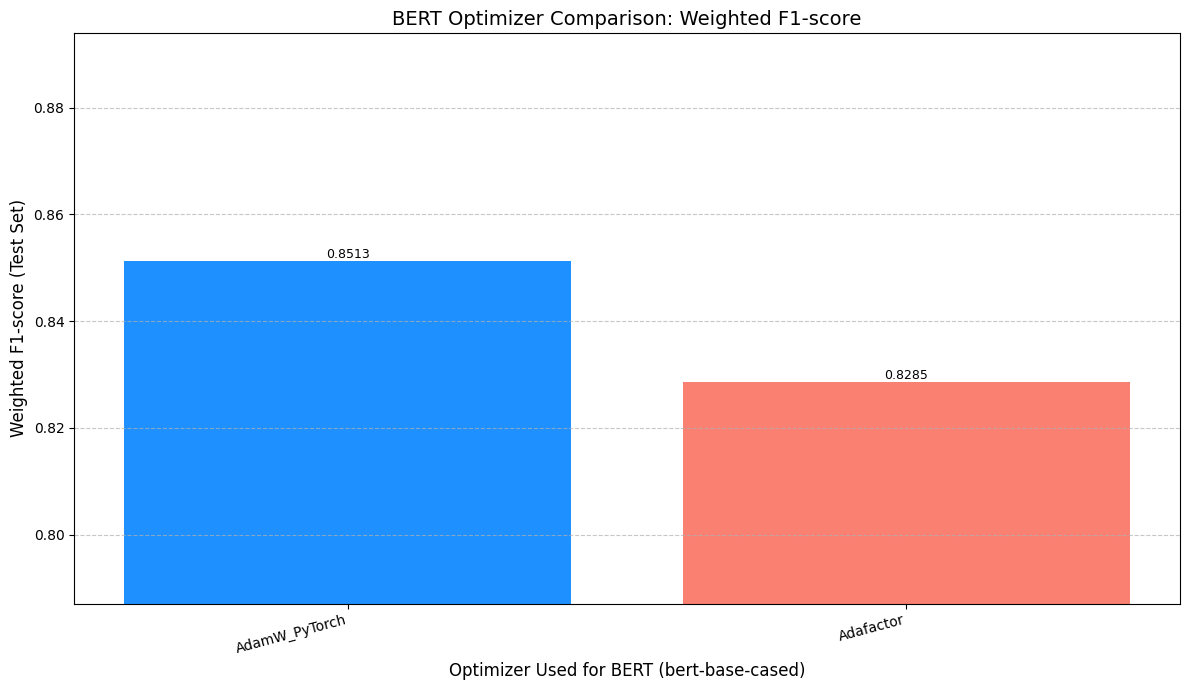

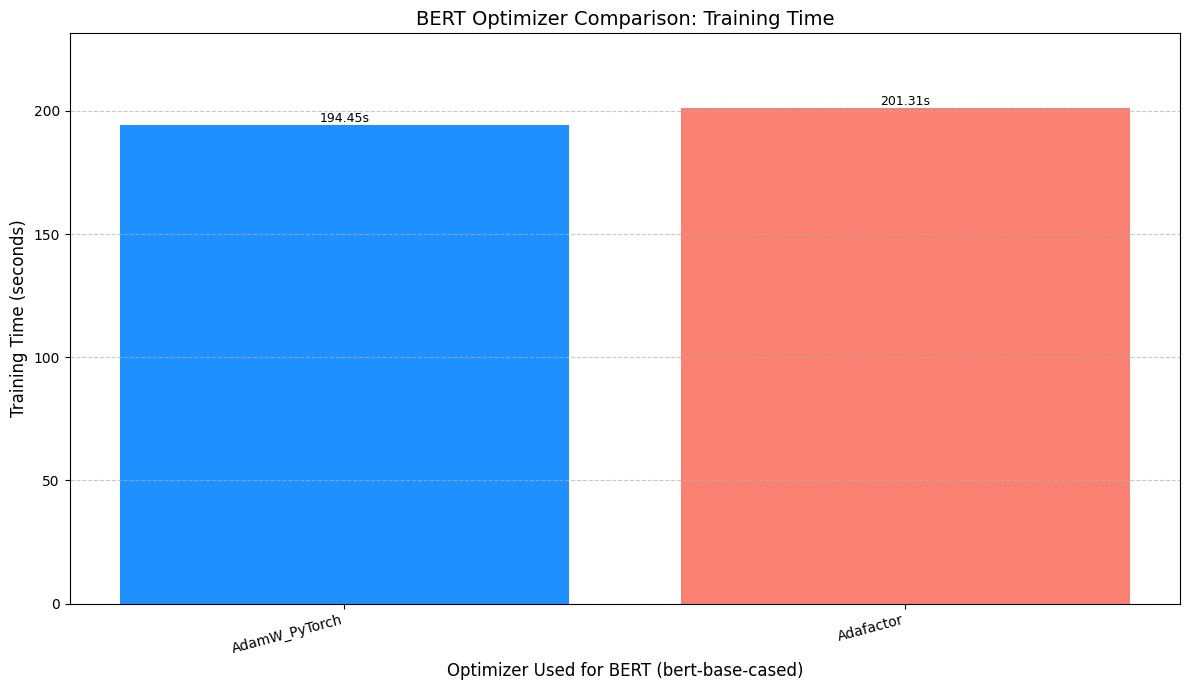

\n--- Detailed Classification Reports for BERT Optimizer Experiment ---
\n--- Report for BERT with Optimizer: AdamW_PyTorch ---
              precision    recall  f1-score   support

          AC     0.8446    0.9099    0.8760      1887
          LF     0.7491    0.8343    0.7894      1020

   micro avg     0.8104    0.8834    0.8453      2907
   macro avg     0.7968    0.8721    0.8327      2907
weighted avg     0.8111    0.8834    0.8456      2907

\n--- Report for BERT with Optimizer: Adafactor ---
              precision    recall  f1-score   support

          AC     0.8335    0.9152    0.8724      1887
          LF     0.6803    0.7843    0.7286      1020

   micro avg     0.7780    0.8693    0.8211      2907
   macro avg     0.7569    0.8498    0.8005      2907
weighted avg     0.7797    0.8693    0.8220      2907



In [ ]:
# Cell 14: Plotting Optimizer Experiment Results - Bar Graphs

optimizer_names_plot_exp = list(optimizer_results_storage.keys())
optimizer_f1_scores_plot_exp = [optimizer_results_storage[name]["metrics"].get("f1_weighted", 0.0) for name in optimizer_names_plot_exp]
optimizer_training_times_plot_exp = [optimizer_results_storage[name]["training_time_seconds"] for name in optimizer_names_plot_exp]

# Plotting Weighted F1 Scores
plt.figure(figsize=(12, 7))
bars_f1_opt = plt.bar(optimizer_names_plot_exp, optimizer_f1_scores_plot_exp, color=['dodgerblue', 'salmon', 'lightgreen'])
plt.xlabel("Optimizer Used for BERT (bert-base-cased)", fontsize=12)
plt.ylabel("Weighted F1-score (Test Set)", fontsize=12)
plt.title("BERT Optimizer Comparison: Weighted F1-score", fontsize=14)
min_f1 = min(optimizer_f1_scores_plot_exp) if optimizer_f1_scores_plot_exp else 0
max_f1 = max(optimizer_f1_scores_plot_exp) if optimizer_f1_scores_plot_exp else 0.1
plt.ylim(max(0, min_f1 * 0.95), min(1, max_f1 * 1.05))
plt.xticks(rotation=15, ha="right")
for bar in bars_f1_opt:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', ha='center', va='bottom', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plotting Training Times
plt.figure(figsize=(12, 7))
bars_time_opt = plt.bar(optimizer_names_plot_exp, optimizer_training_times_plot_exp, color=['dodgerblue', 'salmon', 'lightgreen'])
plt.xlabel("Optimizer Used for BERT (bert-base-cased)", fontsize=12)
plt.ylabel("Training Time (seconds)", fontsize=12)
plt.title("BERT Optimizer Comparison: Training Time", fontsize=14)
plt.xticks(rotation=15, ha="right")
if optimizer_training_times_plot_exp:
     plt.ylim(0, max(optimizer_training_times_plot_exp) * 1.15 if max(optimizer_training_times_plot_exp) > 0 else 10)
for bar in bars_time_opt:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}s', ha='center', va='bottom', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\\n--- Detailed Classification Reports for BERT Optimizer Experiment ---")
for optimizer_name, results_data in optimizer_results_storage.items():
    print(f"\\n--- Report for BERT with Optimizer: {optimizer_name} ---")
    print(results_data["full_report_str"])

\nPlotting Confusion Matrix for BERT with best optimizer: AdamW_PyTorch


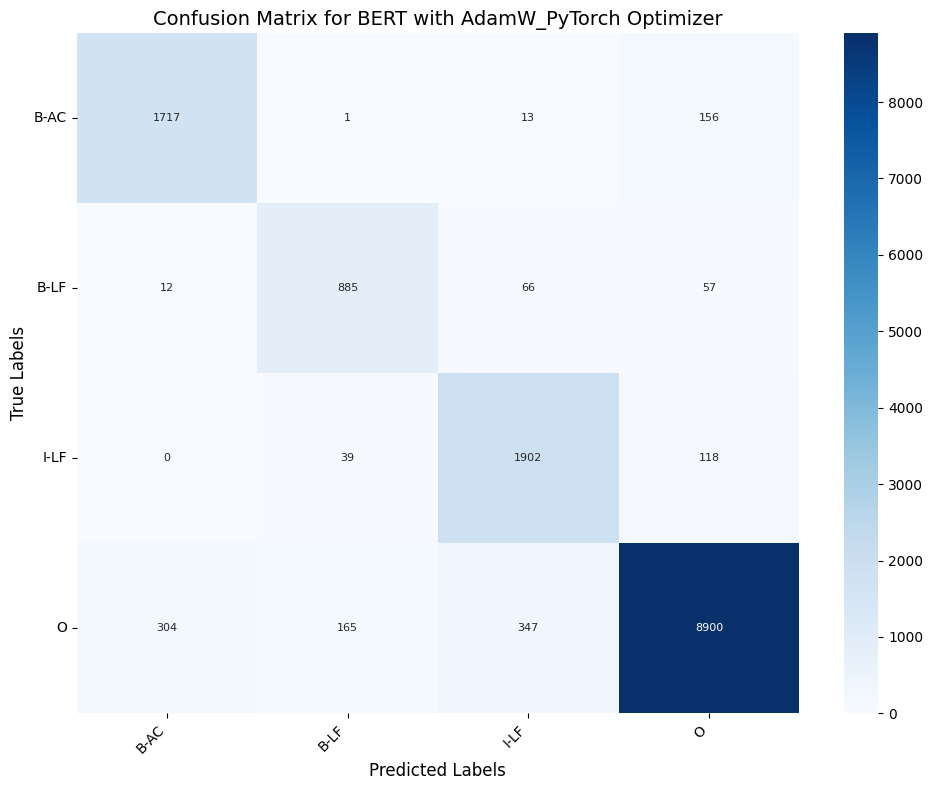

In [ ]:
# Cell 15: Plotting Confusion Matrix for Best Optimizer in BERT Experiment

if optimizer_results_storage:
    best_optimizer_name_exp = max(optimizer_results_storage,
                                  key=lambda k: optimizer_results_storage[k]["metrics"].get("f1_weighted", 0.0))
    print(f"\\nPlotting Confusion Matrix for BERT with best optimizer: {best_optimizer_name_exp}")

    true_labels_cm_opt = optimizer_true_labels_storage.get(best_optimizer_name_exp, [])
    pred_labels_cm_opt = optimizer_test_predictions_storage.get(best_optimizer_name_exp, [])

    if true_labels_cm_opt and pred_labels_cm_opt:
        cm_labels_opt = sorted(list(set(true_labels_cm_opt + pred_labels_cm_opt)))
        cm_opt = confusion_matrix(true_labels_cm_opt, pred_labels_cm_opt, labels=cm_labels_opt)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues',
                    xticklabels=cm_labels_opt, yticklabels=cm_labels_opt, annot_kws={"size": 8})
        plt.xlabel('Predicted Labels', fontsize=12)
        plt.ylabel('True Labels', fontsize=12)
        plt.title(f'Confusion Matrix for BERT with {best_optimizer_name_exp} Optimizer', fontsize=14)
        plt.xticks(rotation=45, ha="right", fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Could not retrieve predictions/labels for {best_optimizer_name_exp} to plot confusion matrix.")
else:
    print("No BERT optimizer experiment results to plot confusion matrix.")

---

## Experiment 5: exp_3_2.ipynb

Content from exp_3_2.ipynb

In [17]:
from datasets import load_dataset
import numpy as np
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification, TrainerCallback
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import logging
import pickle
from transformers import RobertaForTokenClassification
import matplotlib.pyplot as plt
import pickle
import numpy as np
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    try:
        device = xm.xla_device()
    except:
        device = torch.device("cpu")
print(device)

cuda


In [3]:
# Set up logging to a file
logging.basicConfig(
    filename='/content/drive/MyDrive/NLP_CW/training_progress.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [4]:
# Ensure console output as well
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(console_handler)
print('1')

In [5]:
# Load the dataset
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

In [6]:
# Initialize the fast tokenizer (RoBERTa)
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", add_prefix_space=True)

In [7]:
# Define label mapping
label2id = {0: 'O', 1: 'B-AC', 2: 'B-LF', 3: 'I-LF'}
id2label = {v: k for k, v in label2id.items()}
num_labels = len(label2id)

In [8]:
# Prepare dataset for token classification
def prepare_dataset(dataset_split):
    encodings = tokenizer(
        dataset_split["tokens"],
        is_split_into_words=True,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    labels = []
    for i, label_seq in enumerate(dataset_split["ner_tags"]):
        word_ids = encodings.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(id2label[label_seq[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    encodings["labels"] = torch.tensor(labels, dtype=torch.long)
    return encodings

In [9]:
# Custom dataset class to make the tokenized data compatible with Trainer
class TokenClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx=None, **kwargs):
        if idx is None and "idx" in kwargs:
            idx = kwargs["idx"]
        if idx is None:
            raise ValueError("Index (idx) must be provided to __getitem__")
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [26]:
# Prepare datasets
train_dataset = prepare_dataset(dataset["train"])
val_dataset = prepare_dataset(dataset["validation"])
test_dataset = prepare_dataset(dataset["test"])

# Convert datasets to custom dataset format
train_dataset = TokenClassificationDataset(train_dataset)
val_dataset = TokenClassificationDataset(val_dataset)
test_dataset = TokenClassificationDataset(test_dataset)
print('2')

2


In [11]:

class CustomRobertaForTokenClassification(RobertaForTokenClassification):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Filter out unexpected keyword arguments
        relevant_kwargs = {k: v for k, v in kwargs.items() if k in ["head_mask", "inputs_embeds", "output_attentions", "output_hidden_states", "return_dict"]}

        # Pass labels directly to the parent class's forward method
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,  # parent class handle the loss computation
            **relevant_kwargs
        )

        # The parent class returns a tuple (loss, logits) if labels are provided, otherwise just logits
        return outputs


In [12]:
#RoBERTa model with the custom class
model = CustomRobertaForTokenClassification.from_pretrained("roberta-base", num_labels=num_labels, id2label=id2label, label2id=label2id)


Some weights of CustomRobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [14]:
import evaluate
metrics = evaluate.load("seqeval")
def compute_metrics(p):
    label_list = ['O', 'B-AC', 'B-LF', 'I-LF']

    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]


    results = metrics.compute(predictions = true_predictions, references = true_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [27]:
# Plot metrics
def plot_metrics(log_history):
    train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
    train_epoch = [entry['epoch'] for entry in log_history if 'loss' in entry]
    eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
    eval_epoch = [entry['epoch'] for entry in log_history if 'eval_loss' in entry]
    eval_accuracy = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]
    eval_f1 = [entry['eval_f1'] for entry in log_history if 'eval_f1' in entry]

    plt.figure(figsize=(10, 5))
    plt.plot(train_epoch, train_loss, label='Train Loss', color='blue', linestyle='-', markersize=6, linewidth=2)
    plt.plot(eval_epoch, eval_loss, label='Validation Loss',  color='red', linestyle='-.', markersize=6, linewidth=2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Training vs Validation Loss", fontsize=16)
    plt.legend(title='Loss Type', fontsize=12)
    plt.grid(True)
    plt.savefig('/content/drive/MyDrive/NLP_CW/results/loss_vs_epochs.png')
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.plot(range(0, len(eval_accuracy)), eval_accuracy, label='Validation Accuracy',marker='o', color='green', linestyle='-')
    plt.plot(range(0, len(eval_f1)), eval_f1, label='Validation F1 Score',marker='o', color='red', linestyle='--')
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("Validation F1 and Accuracy", fontsize=16)
    plt.legend(title='Metric', fontsize=12)
    plt.grid(True)
    plt.savefig('/content/drive/MyDrive/NLP_CW/results/f1_accuracy_vs_epochs.png')
    plt.close()

    label2id = {0: 'O', 1: 'B-AC', 2: 'B-LF', 3: 'I-LF'}
    labels = list(label2id.values())

    try:
        with open('/content/drive/MyDrive/NLP_CW/test_predictions.pkl', 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        print("Error: test_predictions.pkl not found. Ensure evaluate_and_save_predictions was called successfully.")
        return

    predictions = data['predictions']
    true_labels = data['labels']
    #Normalised confusion matric
    cm = confusion_matrix(true_labels, predictions, labels=list(label2id.keys()))
    cm_normalized = np.zeros_like(cm, dtype=float)
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        if row_sum > 0:
            cm_normalized[i, :] = cm[i, :] / row_sum * 100  # Convert to percentage

    plt.figure(figsize=(8, 6))
    im = plt.imshow(cm_normalized, interpolation='nearest', cmap='twilight', vmin=0, vmax=100)
    cbar = plt.colorbar(im, label='Normalised')
    cbar.set_ticks([0, 20, 40, 60, 80, 100])
    cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title('Confusion Matrix for NER on Test Set', fontsize=16)

    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm_normalized[i, j]:.1f}%',
                     ha="center", va="center",
                     color="black" if cm_normalized[i, j] > thresh else "black",
                     fontsize=12)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/NLP_CW/results/confusion_matrix.png')
    plt.close()
print('3')

3


In [25]:
# Custom evaluation function to save predictions and labels
def evaluate_and_save_predictions(trainer, dataset, output_file='/content/drive/MyDrive/NLP_CW/test_predictions.pkl'):
    predictions = trainer.predict(dataset)
    preds = predictions.predictions.argmax(-1)
    labels = predictions.label_ids
    mask = labels != -100
    flat_preds = preds[mask].flatten()
    flat_labels = labels[mask].flatten()
    with open(output_file, 'wb') as f:
        pickle.dump({'predictions': flat_preds, 'labels': flat_labels}, f)
    return flat_preds, flat_labels

In [23]:
# Define training arguments
lr1=1e-6
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP_CW/results",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit = 1,
    learning_rate=lr1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    data_seed=28,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    report_to="none",
    logging_steps=5,
    logging_strategy="steps",
)


In [24]:
optimizer1 = optim.AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay)

In [18]:
# Initialize Trainer with the custom optimizer and callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    optimizers=(optimizer1,None),
)
print('5')
# Train the model
trainer.train()
# Evaluate on test set and save predictions
test_results = trainer.evaluate(test_dataset)
print("\n=== Test Set Results ===")
print(test_results)
logger.info(f"Test Set Results: {test_results}")

# Save predictions and labels for confusion matrix
evaluate_and_save_predictions(trainer, test_dataset)



Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.498200,0.462105,0.547434,0.441103,0.488550,0.835415
2,0.252700,0.311501,0.715922,0.783208,0.748055,0.895295
3,0.257500,0.288232,0.724512,0.837093,0.776744,0.900086
4,0.257700,0.283444,0.738987,0.840852,0.786635,0.901454
5,0.232600,0.276216,0.737758,0.849624,0.789750,0.903678
6,0.276800,0.278206,0.742639,0.853383,0.794169,0.904705
7,0.153600,0.273804,0.742888,0.850877,0.793224,0.904363
8,0.225500,0.273207,0.742607,0.849624,0.792519,0.904021


2025-05-16 10:31:41,319 - INFO - Test Set Results: {'eval_loss': 0.1834990233182907, 'eval_precision': 0.7850725639253628, 'eval_recall': 0.9205834683954619, 'eval_f1': 0.8474449832152182, 'eval_accuracy': 0.9337117372795459, 'eval_runtime': 0.8362, 'eval_samples_per_second': 298.958, 'eval_steps_per_second': 38.267, 'epoch': 8.0}



=== Test Set Results ===
{'eval_loss': 0.1834990233182907, 'eval_precision': 0.7850725639253628, 'eval_recall': 0.9205834683954619, 'eval_f1': 0.8474449832152182, 'eval_accuracy': 0.9337117372795459, 'eval_runtime': 0.8362, 'eval_samples_per_second': 298.958, 'eval_steps_per_second': 38.267, 'epoch': 8.0}


(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [21]:
plot_metrics(trainer.state.log_history)

In [18]:
# Define training arguments
lr2=3e-3
training_args2 = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP_CW/results",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit = 1,
    learning_rate=lr2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    data_seed=28,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    report_to="none",
    logging_steps=5,
    logging_strategy="steps",
)


In [20]:
optimizer2 = optim.SGD(model.parameters(),lr=lr2)

total_steps = training_args2.num_train_epochs * (len(train_dataset) // training_args2.per_device_train_batch_size)

if len(train_dataset) % training_args2.per_device_train_batch_size != 0:
    total_steps += 1
warmup_steps = int(0.1 * total_steps)  # Warmup for 10% of total steps
scheduler2 = get_linear_schedule_with_warmup(
    optimizer2,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [21]:
# Initialize Trainer with the custom optimizer and callback
trainer2 = Trainer(
    model=model,
    args=training_args2,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    optimizers=(optimizer2,scheduler2),
)

# Train the model
trainer2.train()
# Evaluate on test set and save predictions
test_results2 = trainer2.evaluate(test_dataset)
print("\n=== Test Set Results ===")
print(test_results2)
logger.info(f"Test Set Results: {test_results2}")

# Save predictions and labels for confusion matrix
evaluate_and_save_predictions(trainer2, test_dataset)



Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.556000,0.524207,0.102410,0.021303,0.035270,0.761848
2,0.289900,0.337605,0.687067,0.745614,0.715144,0.892216
3,0.281200,0.299991,0.726363,0.818296,0.769593,0.899914
4,0.297100,0.285829,0.730897,0.827068,0.776014,0.900086
5,0.257300,0.280245,0.731230,0.842105,0.782761,0.902652
6,0.331700,0.279099,0.735746,0.840852,0.784795,0.904021
7,0.176900,0.275165,0.738987,0.840852,0.786635,0.903678
8,0.264700,0.274679,0.741474,0.844612,0.789690,0.904876


2025-05-16 10:40:41,877 - INFO - Test Set Results: {'eval_loss': 0.19529391825199127, 'eval_precision': 0.7876420454545454, 'eval_recall': 0.8987034035656402, 'eval_f1': 0.8395155185465556, 'eval_accuracy': 0.9327995134806406, 'eval_runtime': 0.8376, 'eval_samples_per_second': 298.476, 'eval_steps_per_second': 38.205, 'epoch': 8.0}



=== Test Set Results ===
{'eval_loss': 0.19529391825199127, 'eval_precision': 0.7876420454545454, 'eval_recall': 0.8987034035656402, 'eval_f1': 0.8395155185465556, 'eval_accuracy': 0.9327995134806406, 'eval_runtime': 0.8376, 'eval_samples_per_second': 298.476, 'eval_steps_per_second': 38.205, 'epoch': 8.0}


(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [22]:
plot_metrics(trainer2.state.log_history)